In [11]:
# import Library and some random image data set
import tensorflow as tf
import numpy      as np
import seaborn    as sns 
import pandas     as pd
import os,sys
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
np.random.seed(78); tf.set_random_seed(78)

# get some of the STL data set
from sklearn.preprocessing import OneHotEncoder
from skimage import util 
from skimage.transform import resize
from skimage.io import imread
import warnings
from numpy import inf

from scipy.stats import kurtosis,skew

plt.rcParams.update({'font.size': 10})
import warnings
warnings.filterwarnings("ignore")
import gc
from IPython.display import display, clear_output
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
from matplotlib import animation
%load_ext jupyternotify

<IPython.core.display.Javascript object>

<h1>Things to compare</h1>
<div>
<ol>
  <li>Z: Baseline </li>
  <li>A: abs(Theta)  </li>
  <li>B: Theta ^ 2</li>
  <li>C: sqrt(Theta ^ 2) </li>
  <li>D: - log(1+Theta ^ 2)</li>
  <li>E: - tanh(Theta) </li>
  <li>F: - tanh(Theta^2)</li>
  <li>G: - tanh(abs(Theta))</li>
  <li>H: - tanh(abs(Theta)^2)</li>
  <li>I:   sin(Theta)</li>
  <li>J:   abs(sin(Theta))</li>
  <li>K:   log(Theta^2)</li>
  <li>L:   Theta * log(Theta^2)</li>
</ol>
</div>

<div>
<ol>
  <li>CNN - no batch </li>
  <li>CNN - batch </li>
  <li>FNN - no batch </li>
  <li>FNN - batch </li>
</ol>
</div>

In [2]:
# read all of the data
# https://github.com/mttk/STL10
plt.rcParams.update({'font.size': 10})
def read_all_images(path_to_data):
    """
    :param path_to_data: the file containing the binary images from the STL-10 dataset
    :return: an array containing all the images
    """

    with open(path_to_data, 'rb') as f:
        # read whole file in uint8 chunks
        everything = np.fromfile(f, dtype=np.uint8)

        # We force the data into 3x96x96 chunks, since the
        # images are stored in "column-major order", meaning
        # that "the first 96*96 values are the red channel,
        # the next 96*96 are green, and the last are blue."
        # The -1 is since the size of the pictures depends
        # on the input file, and this way numpy determines
        # the size on its own.

        images = np.reshape(everything, (-1, 3, 96, 96))

        # Now transpose the images into a standard image format
        # readable by, for example, matplotlib.imshow
        # You might want to comment this line or reverse the shuffle
        # if you will use a learning algorithm like CNN, since they like
        # their channels separated.
        images = np.transpose(images, (0, 3, 2, 1))
        return images
def read_labels(path_to_labels):
    """
    :param path_to_labels: path to the binary file containing labels from the STL-10 dataset
    :return: an array containing the labels
    """
    with open(path_to_labels, 'rb') as f:
        labels = np.fromfile(f, dtype=np.uint8)
        return labels
def show_images(data,row=1,col=1):
    fig=plt.figure(figsize=(10,10))
    columns = col; rows = row
    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        plt.imshow(data[i-1])
    plt.show()

train_images = read_all_images("../../../DataSet/STL10/stl10_binary/train_X.bin") / 255.0
train_labels = read_labels    ("../../../DataSet/STL10/stl10_binary/train_Y.bin")
test_images  = read_all_images("../../../DataSet/STL10/stl10_binary/test_X.bin")  / 255.0
test_labels  = read_labels    ("../../../DataSet/STL10/stl10_binary/test_y.bin")

label_encoder= OneHotEncoder(sparse=False,categories='auto')
train_labels = label_encoder.fit_transform(train_labels.reshape((-1,1)))
test_labels  = label_encoder.fit_transform(test_labels.reshape((-1,1)))

print(train_images.shape,train_images.max(),train_images.min())
print(train_labels.shape,train_labels.max(),train_labels.min())
print(test_images.shape,test_images.max(),test_images.min())
print(test_labels.shape,test_labels.max(),test_labels.min())

(5000, 96, 96, 3) 1.0 0.0
(5000, 10) 1.0 0.0
(8000, 96, 96, 3) 1.0 0.0
(8000, 10) 1.0 0.0


In [19]:
# create the layers
def tf_softmax(x): return tf.nn.softmax(x)

def tf_relu(x):   return tf.nn.relu(x)
def d_tf_relu(x): return tf.cast(tf.greater(x,0),tf.float32)

class CNN():

    def __init__(self,k,inc,out, stddev=0.05,which_reg=0,act=tf_relu,d_act=d_tf_relu):
        self.w              = tf.Variable(tf.random_normal([k,k,inc,out],stddev=stddev,seed=2,dtype=tf.float32))
        self.m,self.v       = tf.Variable(tf.zeros_like(self.w)),tf.Variable(tf.zeros_like(self.w))
        self.act,self.d_act = act,d_act
        self.regularizer    = which_reg
        
    def getw(self): return self.w

    def feedforward(self,input,stride=1,padding='SAME'):
        self.input  = input
        self.layer  = tf.nn.conv2d(input,self.w,strides=[1,stride,stride,1],padding=padding) 
        self.layerA = self.act(self.layer)
        return self.layer, self.layerA
    
    def backprop(self,gradient,stride=1,padding='SAME'):
        grad_part_1 = gradient
        grad_part_2 = self.d_act(self.layer)
        grad_part_3 = self.input

        grad_middle = grad_part_1 * grad_part_2
        grad        = tf.nn.conv2d_backprop_filter(input = grad_part_3,filter_sizes = tf.shape(self.w),  out_backprop = grad_middle,strides=[1,stride,stride,1],padding=padding) / batch_size
        grad_pass   = tf.nn.conv2d_backprop_input (input_sizes = tf.shape(self.input),filter= self.w,out_backprop = grad_middle,strides=[1,stride,stride,1],padding=padding)

        if self.regularizer == 'A': grad = grad + lamda * 2.0 * self.w
        if self.regularizer == 'B': grad = grad + lamda * 0.5 * (tf.sign(self.w) + (1.0/tf.sqrt(tf.square(tf.abs(self.w))+ 10e-8)) * tf.abs(self.w) * tf.sign(self.w))
        if self.regularizer == 'C': grad = grad + lamda * tf.ones_like(self.w)
        if self.regularizer == 'D': grad = grad + lamda * (1.0/tf.sqrt(tf.square(self.w)+ 10e-8)) * self.w
        if self.regularizer == 'E': grad = grad + lamda * tf.sign(self.w)
        if self.regularizer == 'F': grad = grad + lamda * (1.0/tf.sqrt(tf.square(tf.abs(self.w))+ 10e-8)) * tf.abs(self.w) * tf.sign(self.w)
        if self.regularizer == 'G': grad = grad + lamda * ( self.w**2/(tf.sqrt(self.w**2)+10e-8) - tf.sqrt(self.w ** 2))/(self.w**2 + 10e-8)
        if self.regularizer == 'H': grad = grad + lamda * -1.0 * (1.0-tf.tanh(self.w) ** 2)
        if self.regularizer == 'I': grad = grad + lamda * -1.0 * (1.0-tf.tanh(self.w ** 2) ** 2) * 2.0 * self.w
        if self.regularizer == 'J': grad = grad + lamda * -1.0 * (1/(1+self.w ** 2)) * 2.0 * self.w
        if self.regularizer == 'K': grad = grad + lamda * -1.0 * (1/(1+self.w ** 2)) * 2.0 * self.w
        if self.regularizer == 'L': grad = grad + lamda * -1.0 * (1/(1+self.w ** 2)) * 2.0 * self.w
        
        update_w = []
        update_w.append(tf.assign( self.m,self.m*beta1 + (1-beta1) * (grad)   ))
        update_w.append(tf.assign( self.v,self.v*beta2 + (1-beta2) * (grad ** 2)   ))
        m_hat = self.m / (1-beta1) ; v_hat = self.v / (1-beta2)
        adam_middle = m_hat * learning_rate/(tf.sqrt(v_hat) + adam_e)
        update_w.append(tf.assign(self.w,tf.subtract(self.w,adam_middle  )))
        
        return grad_pass,grad,update_w
    
def save_to_image(data,name):
    l1g,l2g,l3g,l4g,l5g,l6g = data
    l1g,l2g,l3g,l4g,l5g,l6g = np.asarray(l1g),np.asarray(l2g),np.asarray(l3g),np.asarray(l4g),np.asarray(l5g),np.asarray(l6g)
    plt.figure(figsize=(25,15))
    plt.suptitle('Current Iter : ' + str(iter))
    plt.subplot(231); plt.hist(l1g.ravel(),50); plt.title('layer 1')
    plt.subplot(232); plt.hist(l2g.ravel(),50); plt.title('layer 2')
    plt.subplot(233); plt.hist(l3g.ravel(),50); plt.title('layer 3')
    plt.subplot(234); plt.hist(l4g.ravel(),50); plt.title('layer 4')
    plt.subplot(235); plt.hist(l5g.ravel(),50); plt.title('layer 5')
    plt.subplot(236); plt.hist(l6g.ravel(),50); plt.title('layer 6')
    plt.savefig(name + str(iter)+'.png')
    plt.tight_layout()
    plt.close('all')     
def append_stat(current_list,data,number):
    current_list[0].append(data[number].mean())
    current_list[1].append(data[number].std())
    current_list[2].append(skew    (data[number].ravel()))
    current_list[3].append(kurtosis(data[number].ravel()))
    current_list[4].append(np.count_nonzero(data[number]))
    return current_list
def transform_to_2d(data):
    batch,width,height,chan = data.shape
    return data.reshape((batch*width,height*chan))
def save_to_image(main_data,one,two,three,four,five,six,experiment_name,tran_acc,test_acc,current_exp,iter):
    plt.figure(figsize=(20,40))
    G = gridspec.GridSpec(8, 6)

    plt.figtext(0.5,1.0,"Iter: " + str(iter) + " Histogram Per " + experiment_name,ha="center", va="top", fontsize=35, color="black")
    plt.subplot(G[0, 0]).hist(main_data[0].ravel(),50,color='red');       plt.subplot(G[0, 0]).set_title(experiment_name+' 1')
    plt.subplot(G[0, 1]).hist(main_data[1].ravel(),50,color='orange');    plt.subplot(G[0, 1]).set_title(experiment_name+' 2')
    plt.subplot(G[0, 2]).hist(main_data[2].ravel(),50,color='yellow');  plt.subplot(G[0, 2]).set_title(experiment_name+' 3')
    plt.subplot(G[0, 3]).hist(main_data[3].ravel(),50,color='green');    plt.subplot(G[0, 3]).set_title(experiment_name+' 4')
    plt.subplot(G[0, 4]).hist(main_data[4].ravel(),50,color='blue');     plt.subplot(G[0, 4]).set_title(experiment_name+' 5')
    plt.subplot(G[0, 5]).hist(main_data[5].ravel(),50,color='black');     plt.subplot(G[0, 5]).set_title(experiment_name+' 6')

    plt.subplot(G[1, :]).set_title("Mean Per "+ experiment_name)
    plt.subplot(G[1, :]).plot(one[0]  ,c='red',alpha=0.9,label='1')
    plt.subplot(G[1, :]).plot(two[0]  ,c='orange',alpha=0.9,label='2')
    plt.subplot(G[1, :]).plot(three[0],c='yellow',alpha=0.9,label='3')
    plt.subplot(G[1, :]).plot(four[0],c='green',alpha=0.9,label='4')
    plt.subplot(G[1, :]).plot(five[0],c='blue',alpha=0.9,label='5')
    plt.subplot(G[1, :]).plot(six[0],c='black',alpha=0.9,label='6')
    plt.legend(bbox_to_anchor=(0., 0.95, 1., .05), loc=9,ncol=6, mode="expand", borderaxespad=0.)

    plt.subplot(G[2, :]).set_title("Standard Deviation Per "+ experiment_name)
    plt.subplot(G[2, :]).plot(one[1]  ,c='red',alpha=0.9,label='1')
    plt.subplot(G[2, :]).plot(two[1]  ,c='orange',alpha=0.9,label='2')
    plt.subplot(G[2, :]).plot(three[1],c='yellow',alpha=0.9,label='3')
    plt.subplot(G[2, :]).plot(four[1],c='green',alpha=0.9,label='4')
    plt.subplot(G[2, :]).plot(five[1],c='blue',alpha=0.9,label='5')
    plt.subplot(G[2, :]).plot(six[1],c='black',alpha=0.9,label='6')
    plt.legend(bbox_to_anchor=(0., 0.95, 1., .05), loc=9,ncol=6, mode="expand", borderaxespad=0.)

    plt.subplot(G[3, :]).set_title("Skewness Per "+ experiment_name)
    plt.subplot(G[3, :]).plot(one[2]  ,c='red',alpha=0.9,label='1')
    plt.subplot(G[3, :]).plot(two[2]  ,c='orange',alpha=0.9,label='2')
    plt.subplot(G[3, :]).plot(three[2],c='yellow',alpha=0.9,label='3')
    plt.subplot(G[3, :]).plot(four[2],c='green',alpha=0.9,label='4')
    plt.subplot(G[3, :]).plot(five[2],c='blue',alpha=0.9,label='5')
    plt.subplot(G[3, :]).plot(six[2],c='black',alpha=0.9,label='6')
    plt.legend(bbox_to_anchor=(0., 0.95, 1., .05), loc=9,ncol=6, mode="expand", borderaxespad=0.)

    plt.subplot(G[4, :]).set_title("Kurtosis Per "+ experiment_name)
    plt.subplot(G[4, :]).plot(one[3]  ,c='red',alpha=0.9,label='1')
    plt.subplot(G[4, :]).plot(two[3]  ,c='orange',alpha=0.9,label='2')
    plt.subplot(G[4, :]).plot(three[3],c='yellow',alpha=0.9,label='3')
    plt.subplot(G[4, :]).plot(four[3],c='green',alpha=0.9,label='4')
    plt.subplot(G[4, :]).plot(five[3],c='blue',alpha=0.9,label='5')
    plt.subplot(G[4, :]).plot(six[3],c='black',alpha=0.9,label='6')
    plt.legend(bbox_to_anchor=(0., 0.95, 1., .05), loc=9,ncol=6, mode="expand", borderaxespad=0.)

    plt.subplot(G[5, :]).set_title("# Non-Zero Per "+ experiment_name)
    plt.subplot(G[5, :]).plot(one[4]  ,c='red',alpha=0.9   ,label='1')
    plt.subplot(G[5, :]).plot(two[4]  ,c='orange',alpha=0.9,label='2')
    plt.subplot(G[5, :]).plot(three[4],c='yellow',alpha=0.9,label='3')
    plt.subplot(G[5, :]).plot(four[4],c='green',alpha=0.9  ,label='4')
    plt.subplot(G[5, :]).plot(five[4],c='blue',alpha=0.9   ,label='5')
    plt.subplot(G[5, :]).plot(six[4],c='black',alpha=0.9   ,label='6')
    plt.legend(bbox_to_anchor=(0., 0.95, 1., .05), loc=9,ncol=6, mode="expand", borderaxespad=0.)

    plt.subplot(G[6, :]).set_title("Train/Test accuracy")
    plt.subplot(G[6, :]).plot(train_acc  ,c='red',alpha=0.9, label='Train')
    plt.subplot(G[6, :]).plot(test_acc   ,c='blue',alpha=0.9,label='Test')
    plt.legend()

    plt.figtext(0.5,0,"Correlation Matrix Per "+ experiment_name,ha="center", va="bottom", fontsize=30, color="black")
    plt.subplot(G[7, 0]).imshow(np.corrcoef(transform_to_2d(main_data[0])),cmap='gray')
    plt.subplot(G[7, 1]).imshow(np.corrcoef(transform_to_2d(main_data[1])),cmap='gray')
    plt.subplot(G[7, 2]).imshow(np.corrcoef(transform_to_2d(main_data[2])),cmap='gray')
    plt.subplot(G[7, 3]).imshow(np.corrcoef(transform_to_2d(main_data[3])),cmap='gray')
    plt.subplot(G[7, 4]).imshow(np.corrcoef(transform_to_2d(main_data[4])),cmap='gray')
    plt.subplot(G[7, 5]).imshow(np.corrcoef(transform_to_2d(main_data[5])),cmap='gray')

    plt.tight_layout()
    plt.savefig(current_exp + '/' + experiment_name + '/' + str(iter) + '.png')
    plt.close('all')
def plot_rotation_weight(current_layers,current_layer_number,current_batch_norm_type,current_exp_name): 

    def rotate(angle):ax.view_init(azim=angle)
    plt.rcParams.update({'font.size': 8})
    colors = ['red','orange','yellow','green','blue','purple','black','gold','silver','cyan','pink']
    number_of_eps = [1,2,3,4,5,6,7,8,9,10,11]
    fig = plt.figure(figsize=(10,10))
    ax  = fig.add_subplot(111, projection='3d')
    count = 0
    for episode in range(num_eps+1):
        if episode == num_eps:
            ys   = current_layers.mean(0).flatten()
            xmin = ys.min(); xmax = ys.max(); step = 0.005
            hist,bins = np.histogram(ys, bins=np.linspace(xmin, xmax, (xmax-xmin)/step))
            ax.bar(bins[:-1], hist, width=0.01,zs=episode, zdir='y', color=colors[episode], alpha=0.8)
        else:
            ys   = current_layers[episode].flatten()
            xmin = ys.min(); xmax = ys.max(); step = 0.005
            hist,bins = np.histogram(ys, bins=np.linspace(xmin, xmax, (xmax-xmin)/step))
            ax.bar(bins[:-1], hist, width=0.01,zs=episode, zdir='y', color=colors[episode], alpha=0.4)
    ax.set_xlabel('Values')
    ax.set_ylabel('Episode')
    ax.get_yaxis().set_ticks(np.arange(num_eps+1))
    ax.set_zlabel('Histogram')

    ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

    # make the grid lines transparent
    ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    # ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    #plt.tight_layout()
    plt.show()

    animation.FuncAnimation(fig, rotate, frames=np.arange(0,362,2),interval=100) \
    .save(str(current_batch_norm_type)+'/'+str(current_exp_name)+'/weight_'+str(current_layer_number)+'.gif', dpi=80, writer='imagemagick')

In [4]:
# set hyper parameter
plt.rcParams.update({'font.size': 25})
current_batch_norm_type = 'no_batch_cnn'
num_eps   = 10; num_epoch = 2; learning_rate = 0.0008; batch_size = 20; beta1,beta2,adam_e = 0.9,0.999,1e-9; lamda = 0.00001

In [5]:
# Z
current_exp_name = 'Z'; 
sess = tf.InteractiveSession()
current_exp_train_accuracy = np.zeros((num_eps,num_epoch))
current_exp_test_accuracy  = np.zeros((num_eps,num_epoch))
current_weights_layer1 = np.zeros((num_eps,3,3,3,16))
current_weights_layer2 = np.zeros((num_eps,3,3,16,16))
current_weights_layer3 = np.zeros((num_eps,3,3,16,16))
current_weights_layer4 = np.zeros((num_eps,3,3,16,16))
current_weights_layer5 = np.zeros((num_eps,3,3,16,16))
current_weights_layer6 = np.zeros((num_eps,3,3,16,10))

for episode in range(num_eps):
    sys.stdout.write("""
    ================================================
                Starting Episode: """ + str(episode) +  """
    ================================================\n
    """);sys.stdout.flush();
    
    # create layers
    l1 = CNN(3,3, 16,which_reg=current_exp_name); 
    l2 = CNN(3,16,16,which_reg=current_exp_name); 
    l3 = CNN(3,16,16,which_reg=current_exp_name); 

    l4 = CNN(3,16,16,which_reg=current_exp_name); 
    l5 = CNN(3,16,16,which_reg=current_exp_name); 
    l6 = CNN(3,16,10,which_reg=current_exp_name); 

    # 2. graph 
    x = tf.placeholder(tf.float32,(batch_size,96,96,3))
    y = tf.placeholder(tf.float32,(batch_size,10))

    layer1, layer1a = l1. feedforward(x,stride=2)
    layer2, layer2a = l2. feedforward(layer1a,stride=2)
    layer3, layer3a = l3. feedforward(layer2a,stride=2)
    layer4, layer4a = l4. feedforward(layer3a,stride=2)
    layer5, layer5a = l5. feedforward(layer4a)
    layer6, layer6a = l6. feedforward(layer5a)

    final_layer   = tf.reduce_mean(layer6a,(1,2))
    final_softmax = tf_softmax(final_layer)
    cost          = -tf.reduce_mean(y * tf.log(final_softmax + 1e-8))
    correct_prediction = tf.equal(tf.argmax(final_softmax, 1), tf.argmax(y, 1))
    accuracy           = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    gradient = tf.tile((final_softmax-y)[:,None,None,:],[1,6,6,1])/batch_size
    grad6p,grad6w,grad6_up = l6.backprop(gradient)
    grad5p,grad5w,grad5_up = l5.backprop(grad6p)
    grad4p,grad4w,grad4_up = l4.backprop(grad5p,stride=2)
    grad3p,grad3w,grad3_up = l3.backprop(grad4p,stride=2)
    grad2p,grad2w,grad2_up = l2.backprop(grad3p,stride=2)
    grad1p,grad1w,grad1_up = l1.backprop(grad2p,stride=2)

    gradient_update = grad6_up + grad5_up + grad4_up + grad3_up + grad2_up + grad1_up 

    # train
    sess.run(tf.global_variables_initializer())
    avg_acc_train = 0; avg_acc_test  = 0; train_acc = [];test_acc = []

    for iter in range(num_epoch):

        # Training Accuracy    
        for current_batch_index in range(0,len(train_images),batch_size):
            current_data  = train_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
            current_label = train_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
            sess_results  = sess.run([accuracy,gradient_update],feed_dict={x:current_data,y:current_label})
            sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(train_images)) + ' acc : ' + str(sess_results[0]) + '\r')
            sys.stdout.flush(); avg_acc_train = avg_acc_train + sess_results[0]

        # Test Accuracy    
        for current_batch_index in range(0,len(test_images), batch_size):
            current_data  = test_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
            current_label = test_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
            sess_results  = sess.run([accuracy],feed_dict={x:current_data,y:current_label})
            sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(test_images)) + ' acc : ' + str(sess_results[0]) + '\r')
            sys.stdout.flush(); avg_acc_test = avg_acc_test + sess_results[0]   

        # ======================== print reset ========================
        train_acc.append(avg_acc_train/(len(train_images)/batch_size))
        test_acc .append(avg_acc_test / (len(test_images)/batch_size))
        if iter%2 == 0 :
            sys.stdout.write("Current : "+ str(iter) + "\t" +
                  " Train Acc : " + str(np.around(avg_acc_train/(len(train_images)/batch_size),3)) + "\t" +
                  " Test Acc : "  + str(np.around(avg_acc_test/(len(test_images)/batch_size),3)) + "\t\n")
            sys.stdout.flush();
        avg_acc_train = 0 ; avg_acc_test  = 0
        # ======================== print reset ========================

    # save to episode all of them
    current_exp_train_accuracy[episode,:] = train_acc
    current_exp_test_accuracy[episode,:] = test_acc
    current_weights_layer1[episode] = l1.getw().eval()
    current_weights_layer2[episode] = l2.getw().eval()
    current_weights_layer3[episode] = l3.getw().eval()
    current_weights_layer4[episode] = l4.getw().eval()
    current_weights_layer5[episode] = l5.getw().eval()
    current_weights_layer6[episode] = l6.getw().eval()

sess.close()

# save to gif
# plot_rotation_weight(current_weights_layer1,'1',current_batch_norm_type,current_exp_name)
# plot_rotation_weight(current_weights_layer2,'2',current_batch_norm_type,current_exp_name)
# plot_rotation_weight(current_weights_layer3,'3',current_batch_norm_type,current_exp_name)
# plot_rotation_weight(current_weights_layer4,'4',current_batch_norm_type,current_exp_name)
# plot_rotation_weight(current_weights_layer5,'5',current_batch_norm_type,current_exp_name)
# plot_rotation_weight(current_weights_layer6,'6',current_batch_norm_type,current_exp_name)

# save to image

# save all average and accuracy



                Starting Episode: 0

Current : 0	 Train Acc : 0.121	 Test Acc : 0.175	
Current Iter : 1/2 batch : 7980/8000 acc : 0.15
                Starting Episode: 1

Current : 0	 Train Acc : 0.137	 Test Acc : 0.189	
Current Iter : 1/2 batch : 7980/8000 acc : 0.15
                Starting Episode: 2

Current : 0	 Train Acc : 0.14	 Test Acc : 0.199	
Current Iter : 1/2 batch : 7980/8000 acc : 0.35
                Starting Episode: 3

Current : 0	 Train Acc : 0.133	 Test Acc : 0.199	
Current Iter : 1/2 batch : 7980/8000 acc : 0.35
                Starting Episode: 4

Current : 0	 Train Acc : 0.123	 Test Acc : 0.172	
Current Iter : 1/2 batch : 7980/8000 acc : 0.15
                Starting Episode: 5

Current : 0	 Train Acc : 0.12	 Test Acc : 0.178	
Current Iter : 1/2 batch : 7980/8000 acc : 0.25
                Starting Episode: 6

Current : 0	 Train Acc : 0.116	 Test Acc : 0.169	
Current Iter : 1/2 batch : 7980/8000 acc : 0.35
                Starting Episode: 7

Current : 0	 Train 

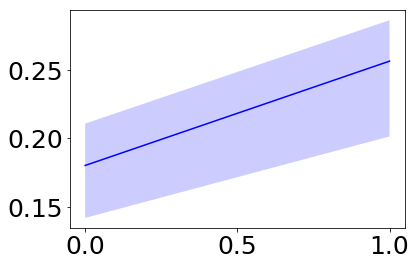

In [6]:
# plot the accuracy min max and mean
plt.plot(current_exp_train_accuracy.max(0),  ' ' ,color='blue')
plt.plot(current_exp_train_accuracy.mean(0), '-' ,color='blue')
plt.plot(current_exp_train_accuracy.min(0) , ' ' ,color='blue')
plt.fill_between(range(num_epoch),current_exp_train_accuracy.max(0),current_exp_train_accuracy.min(0),facecolor='blue', alpha=0.2)
plt.show()

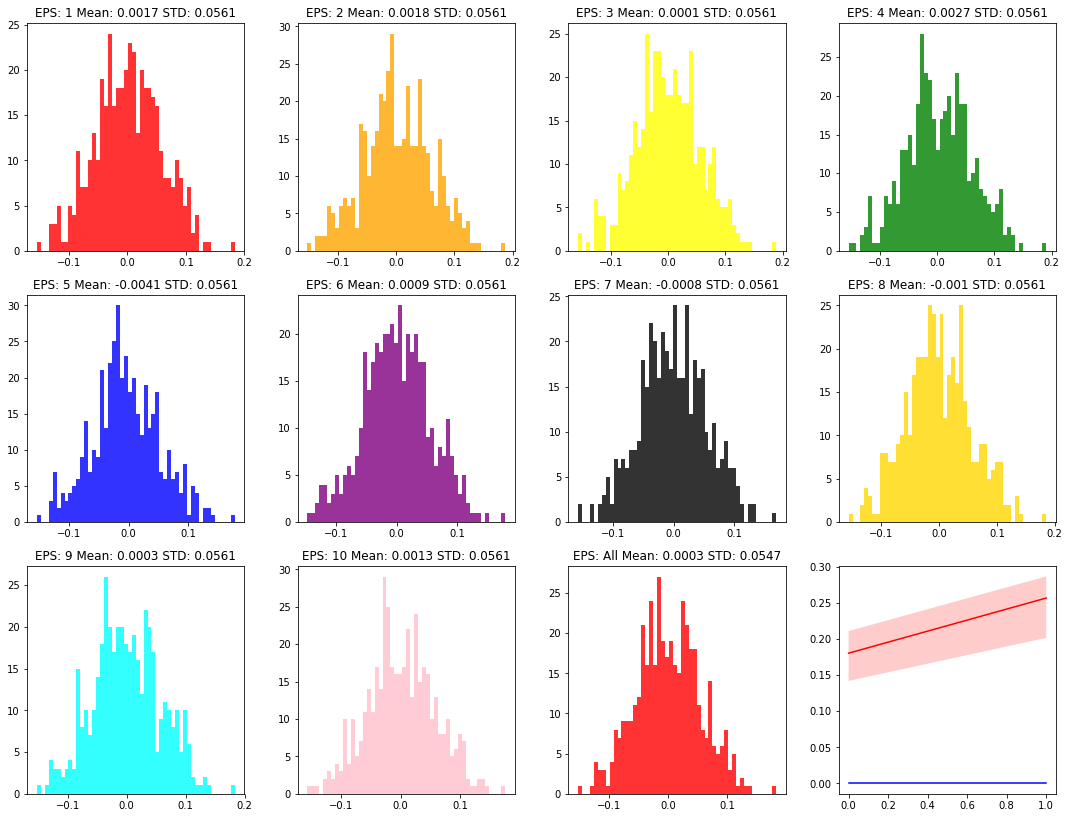

In [56]:
# plot the histogram
def plot_image_weight(current_layers,current_layer_number,current_batch_norm_type,current_exp_name,current_exp_train_accuracy,current_exp_test_accuracy):
    colors = ['red','orange','yellow','green','blue','purple','black','gold','silver','cyan','pink']
    def rt(number): return np.around(number,4)
    plt.rcParams.update({'font.size': 10})
    fig = plt.figure(figsize=(15,15))
    
    fig.add_subplot(441); plt.hist(current_layers[0].flatten(),50,color=colors[0],alpha=0.8);plt.title('EPS: 1 Mean: '+str(rt(current_layers[0].mean())) +' STD: '+str(rt(current_layers[0].std())))
    fig.add_subplot(442); plt.hist(current_layers[1].flatten(),50,color=colors[1],alpha=0.8);plt.title('EPS: 2 Mean: '+str(rt(current_layers[1].mean())) +' STD: '+str(rt(current_layers[0].std())))
    fig.add_subplot(443); plt.hist(current_layers[2].flatten(),50,color=colors[2],alpha=0.8);plt.title('EPS: 3 Mean: '+str(rt(current_layers[2].mean())) +' STD: '+str(rt(current_layers[0].std())))
    fig.add_subplot(444); plt.hist(current_layers[3].flatten(),50,color=colors[3],alpha=0.8);plt.title('EPS: 4 Mean: '+str(rt(current_layers[3].mean())) +' STD: '+str(rt(current_layers[0].std())))
    
    fig.add_subplot(445); plt.hist(current_layers[4].flatten(),50,color=colors[4],alpha=0.8);plt.title('EPS: 5 Mean: '+str(rt(current_layers[4].mean())) +' STD: '+str(rt(current_layers[0].std())))
    fig.add_subplot(446); plt.hist(current_layers[5].flatten(),50,color=colors[5],alpha=0.8);plt.title('EPS: 6 Mean: '+str(rt(current_layers[5].mean())) +' STD: '+str(rt(current_layers[0].std())))
    fig.add_subplot(447); plt.hist(current_layers[6].flatten(),50,color=colors[6],alpha=0.8);plt.title('EPS: 7 Mean: '+str(rt(current_layers[6].mean())) +' STD: '+str(rt(current_layers[0].std())))
    fig.add_subplot(448); plt.hist(current_layers[7].flatten(),50,color=colors[7],alpha=0.8);plt.title('EPS: 8 Mean: '+str(rt(current_layers[7].mean())) +' STD: '+str(rt(current_layers[0].std())))
    
    fig.add_subplot(4,4,9);  plt.hist(current_layers[8].flatten(),50,color=colors[9],alpha=0.8);plt.title('EPS: 9 Mean: '+str(rt(current_layers[8].mean())) +' STD: '+str(rt(current_layers[0].std())))
    fig.add_subplot(4,4,10); plt.hist(current_layers[9].flatten(),50,color=colors[10],alpha=0.8);plt.title('EPS: 10 Mean: '+str(rt(current_layers[9].mean())) +' STD: '+str(rt(current_layers[0].std())))
    fig.add_subplot(4,4,11); plt.hist(current_layers.mean(0).flatten(),50,color=colors[0],alpha=0.8);plt.title('EPS: All Mean: '+str(rt(current_layers.mean(0).mean())) +' STD: '+str(rt(current_layers.mean(0).std())))
    fig.add_subplot(4,4,12); 
    plt.plot(current_exp_train_accuracy.max(0),  ' ' ,color='red')
    plt.plot(current_exp_train_accuracy.mean(0), '-' ,color='red')
    plt.plot(current_exp_train_accuracy.min(0) , ' ' ,color='red')
    plt.fill_between(range(num_epoch),current_exp_train_accuracy.max(0),current_exp_train_accuracy.min(0),facecolor='red', alpha=0.2)

    plt.plot(current_exp_test_accuracy.max(0),  ' ' ,color='blue')
    plt.plot(current_exp_test_accuracy.mean(0), '-' ,color='blue')
    plt.plot(current_exp_test_accuracy.min(0) , ' ' ,color='blue')
    plt.fill_between(range(num_epoch),current_exp_test_accuracy.max(0),current_exp_test_accuracy.min(0),facecolor='blue', alpha=0.2)
    
    plt.tight_layout()
    plt.show()

plot_image_weight(current_weights_layer1,'1',current_batch_norm_type,current_exp_name,current_exp_train_accuracy,current_exp_test_accuracy)
# %notify -m "done"

In [9]:
! start .

In [5]:
# Z
current_exp_name = 'Z';
sess = tf.InteractiveSession()

# create layers
l1 = CNN(3,3, 16,which_reg=current_exp_name); 
l2 = CNN(3,16,16,which_reg=current_exp_name); 
l3 = CNN(3,16,16,which_reg=current_exp_name); 

l4 = CNN(3,16,16,which_reg=current_exp_name); 
l5 = CNN(3,16,16,which_reg=current_exp_name); 
l6 = CNN(3,16,10,which_reg=current_exp_name); 

# 2. graph 
x = tf.placeholder(tf.float32,(batch_size,96,96,3))
y = tf.placeholder(tf.float32,(batch_size,10))

layer1, layer1a = l1. feedforward(x,stride=2)
layer2, layer2a = l2. feedforward(layer1a,stride=2)
layer3, layer3a = l3. feedforward(layer2a,stride=2)
layer4, layer4a = l4. feedforward(layer3a,stride=2)
layer5, layer5a = l5. feedforward(layer4a)
layer6, layer6a = l6. feedforward(layer5a)

final_layer   = tf.reduce_mean(layer6a,(1,2))
final_softmax = tf_softmax(final_layer)
cost          = -tf.reduce_mean(y * tf.log(final_softmax + 1e-8))
correct_prediction = tf.equal(tf.argmax(final_softmax, 1), tf.argmax(y, 1))
accuracy           = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

gradient = tf.tile((final_softmax-y)[:,None,None,:],[1,6,6,1])/batch_size
grad6p,grad6w,grad6_up = l6.backprop(gradient)
grad5p,grad5w,grad5_up = l5.backprop(grad6p)
grad4p,grad4w,grad4_up = l4.backprop(grad5p,stride=2)
grad3p,grad3w,grad3_up = l3.backprop(grad4p,stride=2)
grad2p,grad2w,grad2_up = l2.backprop(grad3p,stride=2)
grad1p,grad1w,grad1_up = l1.backprop(grad2p,stride=2)

gradient_update = grad6_up + grad5_up + grad4_up + grad3_up + grad2_up + grad1_up 

# train
sess.run(tf.global_variables_initializer())
avg_acc_train = 0; avg_acc_test  = 0; train_acc = [];test_acc = []

# mean std skew kurt non-zero
llayer1 = [[],[],[],[],[]]; llayer2 = [[],[],[],[],[]]; llayer3 = [[],[],[],[],[]]
llayer4 = [[],[],[],[],[]]; llayer5 = [[],[],[],[],[]]; llayer6 = [[],[],[],[],[]]

llayer1a = [[],[],[],[],[]]; llayer2a = [[],[],[],[],[]]; llayer3a = [[],[],[],[],[]]
llayer4a = [[],[],[],[],[]]; llayer5a = [[],[],[],[],[]]; llayer6a = [[],[],[],[],[]]

weight1 = [[],[],[],[],[]]; weight2 = [[],[],[],[],[]]; weight3 = [[],[],[],[],[]];
weight4 = [[],[],[],[],[]]; weight5 = [[],[],[],[],[]]; weight6 = [[],[],[],[],[]];

gradw1  = [[],[],[],[],[]]; gradw2  = [[],[],[],[],[]]; gradw3  = [[],[],[],[],[]];
gradw4  = [[],[],[],[],[]]; gradw5  = [[],[],[],[],[]]; gradw6  = [[],[],[],[],[]];

gradp1  = [[],[],[],[],[]]; gradp2  = [[],[],[],[],[]]; gradp3  = [[],[],[],[],[]];
gradp4  = [[],[],[],[],[]]; gradp5  = [[],[],[],[],[]]; gradp6  = [[],[],[],[],[]];

gradup1  = [[],[],[],[],[]]; gradup2  = [[],[],[],[],[]]; gradup3  = [[],[],[],[],[]];
gradup4  = [[],[],[],[],[]]; gradup5  = [[],[],[],[],[]]; gradup6  = [[],[],[],[],[]];

list_of_outputs = [
    layer1,layer2,layer3,layer4,layer5,layer6,
    layer1a,layer2a,layer3a,layer4a,layer5a,layer6a,
    l1.getw(),l2.getw(),l3.getw(),l4.getw(),l5.getw(),l6.getw(),
    grad1w,grad2w,grad3w,grad4w,grad5w,grad6w,
    grad1p,grad2p,grad3p,grad4p,grad5p,grad6p,
    grad1_up[0],grad2_up[0],grad3_up[0],grad4_up[0],grad5_up[0],grad6_up[0]
]

for iter in range(num_epoch):

    # Training Accuracy    
    for current_batch_index in range(0,len(train_images),batch_size):
        current_data  = train_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = train_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy,gradient_update],feed_dict={x:current_data,y:current_label})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(train_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_train = avg_acc_train + sess_results[0]
        
    # get the results
    mid_stat = sess.run(list_of_outputs,feed_dict={x:current_data,y:current_label})
    
    # Test Accuracy    
    for current_batch_index in range(0,len(test_images), batch_size):
        current_data  = test_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = test_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy],feed_dict={x:current_data,y:current_label})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(test_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_test = avg_acc_test + sess_results[0]   
        
    # ======================== extract stats ========================
    llayer1 = append_stat(llayer1,mid_stat,0);  llayer2 = append_stat(llayer2,mid_stat,1);  llayer3 = append_stat(llayer3,mid_stat,2);
    llayer4 = append_stat(llayer4,mid_stat,3);  llayer5 = append_stat(llayer5,mid_stat,4);  llayer6 = append_stat(llayer6,mid_stat,5);

    llayer1a = append_stat(llayer1a,mid_stat,6);  llayer2a = append_stat(llayer2a,mid_stat,7);  llayer3a = append_stat(llayer3a,mid_stat,8);
    llayer4a = append_stat(llayer4a,mid_stat,9);  llayer5a = append_stat(llayer5a,mid_stat,10); llayer6a = append_stat(llayer6a,mid_stat,11);
    
    weight1 = append_stat(weight1,mid_stat,12);  weight2 = append_stat(weight2,mid_stat,13);  weight3 = append_stat(weight3,mid_stat,14);
    weight4 = append_stat(weight4,mid_stat,15);  weight5 = append_stat(weight5,mid_stat,16);  weight6 = append_stat(weight6,mid_stat,17);
    
    gradw1 = append_stat(gradw1,mid_stat,18); gradw2 = append_stat(gradw2,mid_stat,19); gradw3 = append_stat(gradw3,mid_stat,20);
    gradw4 = append_stat(gradw4,mid_stat,21); gradw5 = append_stat(gradw5,mid_stat,22); gradw6 = append_stat(gradw6,mid_stat,23);
    
    gradp1 = append_stat(gradp1,mid_stat,24); gradp2 = append_stat(gradp2,mid_stat,25); gradp3 = append_stat(gradp3,mid_stat,26);
    gradp4 = append_stat(gradp4,mid_stat,27); gradp5 = append_stat(gradp5,mid_stat,28); gradp6 = append_stat(gradp6,mid_stat,29);

    gradup1 = append_stat(gradup1,mid_stat,30); gradup2 = append_stat(gradup2,mid_stat,31); gradup3 = append_stat(gradup3,mid_stat,32);
    gradup4 = append_stat(gradup4,mid_stat,33); gradup5 = append_stat(gradup5,mid_stat,34); gradup6 = append_stat(gradup6,mid_stat,35);

    train_acc.append(avg_acc_train/(len(train_images)/batch_size))
    test_acc .append(avg_acc_test / (len(test_images)/batch_size))
    # ======================== extract stats ========================
    
    # ======================== save to image ========================
    save_to_image(mid_stat[0:6]   ,llayer1,llayer2,llayer3,llayer4,llayer5,llayer6,"layer",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[6:12]  ,llayer1a,llayer2a,llayer3a,llayer4a,llayer5a,llayer6a,"layera",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[12:18] ,weight1,weight2,weight3,weight4,weight5,weight6,"weights",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[18:24] ,gradw1,gradw2,gradw3,gradw4,gradw5,gradw6,"gradientw",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[24:30] ,gradp1,gradp2,gradp3,gradp4,gradp5,gradp6,"gradientp",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[30:36] ,gradup1,gradup2,gradup3,gradup4,gradup5,gradup6,"moment",train_acc,test_acc,current_exp_name,iter)
    # ======================== save to image ========================
        
    # ======================== print reset ========================
    print("Current : "+ str(iter) + " Train Acc : " + str(avg_acc_train/(len(train_images)/batch_size)) + " Test Acc : " + str(avg_acc_test/(len(test_images)/batch_size)) + '\n')
    avg_acc_train = 0 ; avg_acc_test  = 0
    # ======================== print reset ========================

np.save(current_exp_name+'/train_acc.npy',train_acc); np.save(current_exp_name+'/test_acc.npy', test_acc)    
np.save(current_exp_name+'/llayer1.npy', llayer1);  np.save(current_exp_name+'/llayer2.npy', llayer2);  np.save(current_exp_name+'/llayer3.npy', llayer3); 
np.save(current_exp_name+'/llayer4.npy', llayer4);  np.save(current_exp_name+'/llayer5.npy', llayer5);  np.save(current_exp_name+'/llayer6.npy', llayer6); 

np.save(current_exp_name+'/llayer1a.npy', llayer1a);  np.save(current_exp_name+'/llayer2a.npy', llayer2a);  np.save(current_exp_name+'/llayer3a.npy', llayer3a); 
np.save(current_exp_name+'/llayer4a.npy', llayer4a);  np.save(current_exp_name+'/llayer5a.npy', llayer5a);  np.save(current_exp_name+'/llayer6a.npy', llayer6a); 

np.save(current_exp_name+'/weight1.npy', weight1);  np.save(current_exp_name+'/weight2.npy', weight2);  np.save(current_exp_name+'/weight3.npy', weight3);  
np.save(current_exp_name+'/weight4.npy', weight4);  np.save(current_exp_name+'/weight5.npy', weight5);  np.save(current_exp_name+'/weight6.npy', weight6);  

np.save(current_exp_name+'/gradw1.npy', gradw1); np.save(current_exp_name+'/gradw2.npy', gradw2); np.save(current_exp_name+'/gradw3.npy', gradw3);
np.save(current_exp_name+'/gradw4.npy', gradw4); np.save(current_exp_name+'/gradw5.npy', gradw5); np.save(current_exp_name+'/gradw6.npy', gradw6);

np.save(current_exp_name+'/gradp1.npy', gradp1); np.save(current_exp_name+'/gradp2.npy', gradp2); np.save(current_exp_name+'/gradp3.npy', gradp3);
np.save(current_exp_name+'/gradp4.npy', gradp4); np.save(current_exp_name+'/gradp5.npy', gradp5); np.save(current_exp_name+'/gradp6.npy', gradp6);

np.save(current_exp_name+'/gradup1.npy', gradup1); np.save(current_exp_name+'/gradup2.npy', gradup2); np.save(current_exp_name+'/gradup3.npy', gradup3);
np.save(current_exp_name+'/gradup4.npy', gradup4); np.save(current_exp_name+'/gradup5.npy', gradup5); np.save(current_exp_name+'/gradup6.npy', gradup6);

sess.close(); tf.reset_default_graph();

%reset_selective -f l1,l2,l3,l4,l5,l6
%reset_selective -f layer1,layer2,layer3,layer4,layer5,layer6
%reset_selective -f layer1a,layer2a,layer3a,layer4a,layer5a,layer6a
%reset_selective -f train_acc,test_acc,llayer1,llayer2,llayer3,llayer4,llayer5,llayer6,llayer1a,llayer2a,llayer3a,llayer4a,llayer5a,llayer6a
%reset_selective -f weight1,weight2,weight3,weight4,weight5,weight6
%reset_selective -f gradw1,gradw2,gradw3,gradw4,gradw5,gradw6
%reset_selective -f gradp1,gradp2,gradp3,gradp4,gradp5,gradp6
%reset_selective -f gradup1,gradup2,gradup3,gradup4,gradup5,gradup6

Current : 0 Train Acc : 0.11660000236332417 Test Acc : 0.159750002855435

Current : 1 Train Acc : 0.16240000292658807 Test Acc : 0.20162500322796403

Current : 2 Train Acc : 0.232800002977252 Test Acc : 0.27775000233203173

Current : 3 Train Acc : 0.2702000027447939 Test Acc : 0.29712500181980434

Current : 4 Train Acc : 0.2896000024676323 Test Acc : 0.3038750021997839

Current : 5 Train Acc : 0.30340000185370447 Test Acc : 0.31387500192038714

Current : 6 Train Acc : 0.3138000020235777 Test Acc : 0.3185000020544976

Current : 7 Train Acc : 0.320400001257658 Test Acc : 0.3266250020265579

Current : 8 Train Acc : 0.3264000009596348 Test Acc : 0.3303750018402934

Current : 9 Train Acc : 0.3310000019520521 Test Acc : 0.334375001937151

Current : 10 Train Acc : 0.3350000016838312 Test Acc : 0.33825000187382104

Current : 11 Train Acc : 0.33620000129938127 Test Acc : 0.34137500166893003

Current : 12 Train Acc : 0.34300000116229057 Test Acc : 0.34500000135041775

Current : 13 Train Acc : 0.

In [6]:
# A
current_exp_name = 'A';
sess = tf.InteractiveSession()

# create layers
l1 = CNN(3,3, 16,which_reg=current_exp_name); 
l2 = CNN(3,16,16,which_reg=current_exp_name); 
l3 = CNN(3,16,16,which_reg=current_exp_name); 

l4 = CNN(3,16,16,which_reg=current_exp_name); 
l5 = CNN(3,16,16,which_reg=current_exp_name); 
l6 = CNN(3,16,10,which_reg=current_exp_name); 

# 2. graph 
x = tf.placeholder(tf.float32,(batch_size,96,96,3))
y = tf.placeholder(tf.float32,(batch_size,10))

layer1, layer1a = l1. feedforward(x,stride=2)
layer2, layer2a = l2. feedforward(layer1a,stride=2)
layer3, layer3a = l3. feedforward(layer2a,stride=2)
layer4, layer4a = l4. feedforward(layer3a,stride=2)
layer5, layer5a = l5. feedforward(layer4a)
layer6, layer6a = l6. feedforward(layer5a)

final_layer   = tf.reduce_mean(layer6a,(1,2))
final_softmax = tf_softmax(final_layer)
cost          = -tf.reduce_mean(y * tf.log(final_softmax + 1e-8))
correct_prediction = tf.equal(tf.argmax(final_softmax, 1), tf.argmax(y, 1))
accuracy           = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

gradient = tf.tile((final_softmax-y)[:,None,None,:],[1,6,6,1])/batch_size
grad6p,grad6w,grad6_up = l6.backprop(gradient)
grad5p,grad5w,grad5_up = l5.backprop(grad6p)
grad4p,grad4w,grad4_up = l4.backprop(grad5p,stride=2)
grad3p,grad3w,grad3_up = l3.backprop(grad4p,stride=2)
grad2p,grad2w,grad2_up = l2.backprop(grad3p,stride=2)
grad1p,grad1w,grad1_up = l1.backprop(grad2p,stride=2)

gradient_update = grad6_up + grad5_up + grad4_up + grad3_up + grad2_up + grad1_up 

# train
sess.run(tf.global_variables_initializer())
avg_acc_train = 0; avg_acc_test  = 0; train_acc = [];test_acc = []

# mean std skew kurt non-zero
llayer1 = [[],[],[],[],[]]; llayer2 = [[],[],[],[],[]]; llayer3 = [[],[],[],[],[]]
llayer4 = [[],[],[],[],[]]; llayer5 = [[],[],[],[],[]]; llayer6 = [[],[],[],[],[]]

llayer1a = [[],[],[],[],[]]; llayer2a = [[],[],[],[],[]]; llayer3a = [[],[],[],[],[]]
llayer4a = [[],[],[],[],[]]; llayer5a = [[],[],[],[],[]]; llayer6a = [[],[],[],[],[]]

weight1 = [[],[],[],[],[]]; weight2 = [[],[],[],[],[]]; weight3 = [[],[],[],[],[]];
weight4 = [[],[],[],[],[]]; weight5 = [[],[],[],[],[]]; weight6 = [[],[],[],[],[]];

gradw1  = [[],[],[],[],[]]; gradw2  = [[],[],[],[],[]]; gradw3  = [[],[],[],[],[]];
gradw4  = [[],[],[],[],[]]; gradw5  = [[],[],[],[],[]]; gradw6  = [[],[],[],[],[]];

gradp1  = [[],[],[],[],[]]; gradp2  = [[],[],[],[],[]]; gradp3  = [[],[],[],[],[]];
gradp4  = [[],[],[],[],[]]; gradp5  = [[],[],[],[],[]]; gradp6  = [[],[],[],[],[]];

gradup1  = [[],[],[],[],[]]; gradup2  = [[],[],[],[],[]]; gradup3  = [[],[],[],[],[]];
gradup4  = [[],[],[],[],[]]; gradup5  = [[],[],[],[],[]]; gradup6  = [[],[],[],[],[]];

list_of_outputs = [
    layer1,layer2,layer3,layer4,layer5,layer6,
    layer1a,layer2a,layer3a,layer4a,layer5a,layer6a,
    l1.getw(),l2.getw(),l3.getw(),l4.getw(),l5.getw(),l6.getw(),
    grad1w,grad2w,grad3w,grad4w,grad5w,grad6w,
    grad1p,grad2p,grad3p,grad4p,grad5p,grad6p,
    grad1_up[0],grad2_up[0],grad3_up[0],grad4_up[0],grad5_up[0],grad6_up[0]
]

for iter in range(num_epoch):

    # Training Accuracy    
    for current_batch_index in range(0,len(train_images),batch_size):
        current_data  = train_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = train_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy,gradient_update],feed_dict={x:current_data,y:current_label})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(train_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_train = avg_acc_train + sess_results[0]
        
    # get the results
    mid_stat = sess.run(list_of_outputs,feed_dict={x:current_data,y:current_label})
    
    # Test Accuracy    
    for current_batch_index in range(0,len(test_images), batch_size):
        current_data  = test_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = test_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy],feed_dict={x:current_data,y:current_label})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(test_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_test = avg_acc_test + sess_results[0]   
        
    # ======================== extract stats ========================
    llayer1 = append_stat(llayer1,mid_stat,0);  llayer2 = append_stat(llayer2,mid_stat,1);  llayer3 = append_stat(llayer3,mid_stat,2);
    llayer4 = append_stat(llayer4,mid_stat,3);  llayer5 = append_stat(llayer5,mid_stat,4);  llayer6 = append_stat(llayer6,mid_stat,5);

    llayer1a = append_stat(llayer1a,mid_stat,6);  llayer2a = append_stat(llayer2a,mid_stat,7);  llayer3a = append_stat(llayer3a,mid_stat,8);
    llayer4a = append_stat(llayer4a,mid_stat,9);  llayer5a = append_stat(llayer5a,mid_stat,10); llayer6a = append_stat(llayer6a,mid_stat,11);
    
    weight1 = append_stat(weight1,mid_stat,12);  weight2 = append_stat(weight2,mid_stat,13);  weight3 = append_stat(weight3,mid_stat,14);
    weight4 = append_stat(weight4,mid_stat,15);  weight5 = append_stat(weight5,mid_stat,16);  weight6 = append_stat(weight6,mid_stat,17);
    
    gradw1 = append_stat(gradw1,mid_stat,18); gradw2 = append_stat(gradw2,mid_stat,19); gradw3 = append_stat(gradw3,mid_stat,20);
    gradw4 = append_stat(gradw4,mid_stat,21); gradw5 = append_stat(gradw5,mid_stat,22); gradw6 = append_stat(gradw6,mid_stat,23);
    
    gradp1 = append_stat(gradp1,mid_stat,24); gradp2 = append_stat(gradp2,mid_stat,25); gradp3 = append_stat(gradp3,mid_stat,26);
    gradp4 = append_stat(gradp4,mid_stat,27); gradp5 = append_stat(gradp5,mid_stat,28); gradp6 = append_stat(gradp6,mid_stat,29);

    gradup1 = append_stat(gradup1,mid_stat,30); gradup2 = append_stat(gradup2,mid_stat,31); gradup3 = append_stat(gradup3,mid_stat,32);
    gradup4 = append_stat(gradup4,mid_stat,33); gradup5 = append_stat(gradup5,mid_stat,34); gradup6 = append_stat(gradup6,mid_stat,35);

    train_acc.append(avg_acc_train/(len(train_images)/batch_size))
    test_acc .append(avg_acc_test / (len(test_images)/batch_size))
    # ======================== extract stats ========================
    
    # ======================== save to image ========================
    save_to_image(mid_stat[0:6]   ,llayer1,llayer2,llayer3,llayer4,llayer5,llayer6,"layer",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[6:12]  ,llayer1a,llayer2a,llayer3a,llayer4a,llayer5a,llayer6a,"layera",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[12:18] ,weight1,weight2,weight3,weight4,weight5,weight6,"weights",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[18:24] ,gradw1,gradw2,gradw3,gradw4,gradw5,gradw6,"gradientw",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[24:30] ,gradp1,gradp2,gradp3,gradp4,gradp5,gradp6,"gradientp",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[30:36] ,gradup1,gradup2,gradup3,gradup4,gradup5,gradup6,"moment",train_acc,test_acc,current_exp_name,iter)
    # ======================== save to image ========================
        
    # ======================== print reset ========================
    print("Current : "+ str(iter) + " Train Acc : " + str(avg_acc_train/(len(train_images)/batch_size)) + " Test Acc : " + str(avg_acc_test/(len(test_images)/batch_size)) + '\n')
    avg_acc_train = 0 ; avg_acc_test  = 0
    # ======================== print reset ========================

np.save(current_exp_name+'/train_acc.npy',train_acc); np.save(current_exp_name+'/test_acc.npy', test_acc)    
np.save(current_exp_name+'/llayer1.npy', llayer1);  np.save(current_exp_name+'/llayer2.npy', llayer2);  np.save(current_exp_name+'/llayer3.npy', llayer3); 
np.save(current_exp_name+'/llayer4.npy', llayer4);  np.save(current_exp_name+'/llayer5.npy', llayer5);  np.save(current_exp_name+'/llayer6.npy', llayer6); 

np.save(current_exp_name+'/llayer1a.npy', llayer1a);  np.save(current_exp_name+'/llayer2a.npy', llayer2a);  np.save(current_exp_name+'/llayer3a.npy', llayer3a); 
np.save(current_exp_name+'/llayer4a.npy', llayer4a);  np.save(current_exp_name+'/llayer5a.npy', llayer5a);  np.save(current_exp_name+'/llayer6a.npy', llayer6a); 

np.save(current_exp_name+'/weight1.npy', weight1);  np.save(current_exp_name+'/weight2.npy', weight2);  np.save(current_exp_name+'/weight3.npy', weight3);  
np.save(current_exp_name+'/weight4.npy', weight4);  np.save(current_exp_name+'/weight5.npy', weight5);  np.save(current_exp_name+'/weight6.npy', weight6);  

np.save(current_exp_name+'/gradw1.npy', gradw1); np.save(current_exp_name+'/gradw2.npy', gradw2); np.save(current_exp_name+'/gradw3.npy', gradw3);
np.save(current_exp_name+'/gradw4.npy', gradw4); np.save(current_exp_name+'/gradw5.npy', gradw5); np.save(current_exp_name+'/gradw6.npy', gradw6);

np.save(current_exp_name+'/gradp1.npy', gradp1); np.save(current_exp_name+'/gradp2.npy', gradp2); np.save(current_exp_name+'/gradp3.npy', gradp3);
np.save(current_exp_name+'/gradp4.npy', gradp4); np.save(current_exp_name+'/gradp5.npy', gradp5); np.save(current_exp_name+'/gradp6.npy', gradp6);

np.save(current_exp_name+'/gradup1.npy', gradup1); np.save(current_exp_name+'/gradup2.npy', gradup2); np.save(current_exp_name+'/gradup3.npy', gradup3);
np.save(current_exp_name+'/gradup4.npy', gradup4); np.save(current_exp_name+'/gradup5.npy', gradup5); np.save(current_exp_name+'/gradup6.npy', gradup6);

sess.close(); tf.reset_default_graph();

%reset_selective -f l1,l2,l3,l4,l5,l6
%reset_selective -f layer1,layer2,layer3,layer4,layer5,layer6
%reset_selective -f layer1a,layer2a,layer3a,layer4a,layer5a,layer6a
%reset_selective -f train_acc,test_acc,llayer1,llayer2,llayer3,llayer4,llayer5,llayer6,llayer1a,llayer2a,llayer3a,llayer4a,llayer5a,llayer6a
%reset_selective -f weight1,weight2,weight3,weight4,weight5,weight6
%reset_selective -f gradw1,gradw2,gradw3,gradw4,gradw5,gradw6
%reset_selective -f gradp1,gradp2,gradp3,gradp4,gradp5,gradp6
%reset_selective -f gradup1,gradup2,gradup3,gradup4,gradup5,gradup6

Current : 0 Train Acc : 0.12520000219345093 Test Acc : 0.17137500314973295

Current : 1 Train Acc : 0.16260000313818454 Test Acc : 0.16837500305846334

Current : 2 Train Acc : 0.20100000366568566 Test Acc : 0.2147500032838434

Current : 3 Train Acc : 0.2406000030785799 Test Acc : 0.2551250029914081

Current : 4 Train Acc : 0.2748000023216009 Test Acc : 0.2888750022184104

Current : 5 Train Acc : 0.29140000288188456 Test Acc : 0.3045000023022294

Current : 6 Train Acc : 0.3048000024408102 Test Acc : 0.31912500218488277

Current : 7 Train Acc : 0.31300000251829624 Test Acc : 0.3307500015571713

Current : 8 Train Acc : 0.3224000021219254 Test Acc : 0.33987500217743216

Current : 9 Train Acc : 0.33340000224113464 Test Acc : 0.34937500187195836

Current : 10 Train Acc : 0.34400000230968 Test Acc : 0.36100000262260434

Current : 11 Train Acc : 0.35580000130832196 Test Acc : 0.36737500195391476

Current : 12 Train Acc : 0.3604000013321638 Test Acc : 0.37512500140815974

Current : 13 Train Acc

In [7]:
# B
current_exp_name = 'B';
sess = tf.InteractiveSession()

# create layers
l1 = CNN(3,3, 16,which_reg=current_exp_name); 
l2 = CNN(3,16,16,which_reg=current_exp_name); 
l3 = CNN(3,16,16,which_reg=current_exp_name); 

l4 = CNN(3,16,16,which_reg=current_exp_name); 
l5 = CNN(3,16,16,which_reg=current_exp_name); 
l6 = CNN(3,16,10,which_reg=current_exp_name); 

# 2. graph 
x = tf.placeholder(tf.float32,(batch_size,96,96,3))
y = tf.placeholder(tf.float32,(batch_size,10))

layer1, layer1a = l1. feedforward(x,stride=2)
layer2, layer2a = l2. feedforward(layer1a,stride=2)
layer3, layer3a = l3. feedforward(layer2a,stride=2)
layer4, layer4a = l4. feedforward(layer3a,stride=2)
layer5, layer5a = l5. feedforward(layer4a)
layer6, layer6a = l6. feedforward(layer5a)

final_layer   = tf.reduce_mean(layer6a,(1,2))
final_softmax = tf_softmax(final_layer)
cost          = -tf.reduce_mean(y * tf.log(final_softmax + 1e-8))
correct_prediction = tf.equal(tf.argmax(final_softmax, 1), tf.argmax(y, 1))
accuracy           = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

gradient = tf.tile((final_softmax-y)[:,None,None,:],[1,6,6,1])/batch_size
grad6p,grad6w,grad6_up = l6.backprop(gradient)
grad5p,grad5w,grad5_up = l5.backprop(grad6p)
grad4p,grad4w,grad4_up = l4.backprop(grad5p,stride=2)
grad3p,grad3w,grad3_up = l3.backprop(grad4p,stride=2)
grad2p,grad2w,grad2_up = l2.backprop(grad3p,stride=2)
grad1p,grad1w,grad1_up = l1.backprop(grad2p,stride=2)

gradient_update = grad6_up + grad5_up + grad4_up + grad3_up + grad2_up + grad1_up 

# train
sess.run(tf.global_variables_initializer())
avg_acc_train = 0; avg_acc_test  = 0; train_acc = [];test_acc = []

# mean std skew kurt non-zero
llayer1 = [[],[],[],[],[]]; llayer2 = [[],[],[],[],[]]; llayer3 = [[],[],[],[],[]]
llayer4 = [[],[],[],[],[]]; llayer5 = [[],[],[],[],[]]; llayer6 = [[],[],[],[],[]]

llayer1a = [[],[],[],[],[]]; llayer2a = [[],[],[],[],[]]; llayer3a = [[],[],[],[],[]]
llayer4a = [[],[],[],[],[]]; llayer5a = [[],[],[],[],[]]; llayer6a = [[],[],[],[],[]]

weight1 = [[],[],[],[],[]]; weight2 = [[],[],[],[],[]]; weight3 = [[],[],[],[],[]];
weight4 = [[],[],[],[],[]]; weight5 = [[],[],[],[],[]]; weight6 = [[],[],[],[],[]];

gradw1  = [[],[],[],[],[]]; gradw2  = [[],[],[],[],[]]; gradw3  = [[],[],[],[],[]];
gradw4  = [[],[],[],[],[]]; gradw5  = [[],[],[],[],[]]; gradw6  = [[],[],[],[],[]];

gradp1  = [[],[],[],[],[]]; gradp2  = [[],[],[],[],[]]; gradp3  = [[],[],[],[],[]];
gradp4  = [[],[],[],[],[]]; gradp5  = [[],[],[],[],[]]; gradp6  = [[],[],[],[],[]];

gradup1  = [[],[],[],[],[]]; gradup2  = [[],[],[],[],[]]; gradup3  = [[],[],[],[],[]];
gradup4  = [[],[],[],[],[]]; gradup5  = [[],[],[],[],[]]; gradup6  = [[],[],[],[],[]];

list_of_outputs = [
    layer1,layer2,layer3,layer4,layer5,layer6,
    layer1a,layer2a,layer3a,layer4a,layer5a,layer6a,
    l1.getw(),l2.getw(),l3.getw(),l4.getw(),l5.getw(),l6.getw(),
    grad1w,grad2w,grad3w,grad4w,grad5w,grad6w,
    grad1p,grad2p,grad3p,grad4p,grad5p,grad6p,
    grad1_up[0],grad2_up[0],grad3_up[0],grad4_up[0],grad5_up[0],grad6_up[0]
]

for iter in range(num_epoch):

    # Training Accuracy    
    for current_batch_index in range(0,len(train_images),batch_size):
        current_data  = train_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = train_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy,gradient_update],feed_dict={x:current_data,y:current_label})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(train_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_train = avg_acc_train + sess_results[0]
        
    # get the results
    mid_stat = sess.run(list_of_outputs,feed_dict={x:current_data,y:current_label})
    
    # Test Accuracy    
    for current_batch_index in range(0,len(test_images), batch_size):
        current_data  = test_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = test_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy],feed_dict={x:current_data,y:current_label})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(test_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_test = avg_acc_test + sess_results[0]   
        
    # ======================== extract stats ========================
    llayer1 = append_stat(llayer1,mid_stat,0);  llayer2 = append_stat(llayer2,mid_stat,1);  llayer3 = append_stat(llayer3,mid_stat,2);
    llayer4 = append_stat(llayer4,mid_stat,3);  llayer5 = append_stat(llayer5,mid_stat,4);  llayer6 = append_stat(llayer6,mid_stat,5);

    llayer1a = append_stat(llayer1a,mid_stat,6);  llayer2a = append_stat(llayer2a,mid_stat,7);  llayer3a = append_stat(llayer3a,mid_stat,8);
    llayer4a = append_stat(llayer4a,mid_stat,9);  llayer5a = append_stat(llayer5a,mid_stat,10); llayer6a = append_stat(llayer6a,mid_stat,11);
    
    weight1 = append_stat(weight1,mid_stat,12);  weight2 = append_stat(weight2,mid_stat,13);  weight3 = append_stat(weight3,mid_stat,14);
    weight4 = append_stat(weight4,mid_stat,15);  weight5 = append_stat(weight5,mid_stat,16);  weight6 = append_stat(weight6,mid_stat,17);
    
    gradw1 = append_stat(gradw1,mid_stat,18); gradw2 = append_stat(gradw2,mid_stat,19); gradw3 = append_stat(gradw3,mid_stat,20);
    gradw4 = append_stat(gradw4,mid_stat,21); gradw5 = append_stat(gradw5,mid_stat,22); gradw6 = append_stat(gradw6,mid_stat,23);
    
    gradp1 = append_stat(gradp1,mid_stat,24); gradp2 = append_stat(gradp2,mid_stat,25); gradp3 = append_stat(gradp3,mid_stat,26);
    gradp4 = append_stat(gradp4,mid_stat,27); gradp5 = append_stat(gradp5,mid_stat,28); gradp6 = append_stat(gradp6,mid_stat,29);

    gradup1 = append_stat(gradup1,mid_stat,30); gradup2 = append_stat(gradup2,mid_stat,31); gradup3 = append_stat(gradup3,mid_stat,32);
    gradup4 = append_stat(gradup4,mid_stat,33); gradup5 = append_stat(gradup5,mid_stat,34); gradup6 = append_stat(gradup6,mid_stat,35);

    train_acc.append(avg_acc_train/(len(train_images)/batch_size))
    test_acc .append(avg_acc_test / (len(test_images)/batch_size))
    # ======================== extract stats ========================
    
    # ======================== save to image ========================
    save_to_image(mid_stat[0:6]   ,llayer1,llayer2,llayer3,llayer4,llayer5,llayer6,"layer",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[6:12]  ,llayer1a,llayer2a,llayer3a,llayer4a,llayer5a,llayer6a,"layera",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[12:18] ,weight1,weight2,weight3,weight4,weight5,weight6,"weights",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[18:24] ,gradw1,gradw2,gradw3,gradw4,gradw5,gradw6,"gradientw",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[24:30] ,gradp1,gradp2,gradp3,gradp4,gradp5,gradp6,"gradientp",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[30:36] ,gradup1,gradup2,gradup3,gradup4,gradup5,gradup6,"moment",train_acc,test_acc,current_exp_name,iter)
    # ======================== save to image ========================
        
    # ======================== print reset ========================
    print("Current : "+ str(iter) + " Train Acc : " + str(avg_acc_train/(len(train_images)/batch_size)) + " Test Acc : " + str(avg_acc_test/(len(test_images)/batch_size)) + '\n')
    avg_acc_train = 0 ; avg_acc_test  = 0
    # ======================== print reset ========================

np.save(current_exp_name+'/train_acc.npy',train_acc); np.save(current_exp_name+'/test_acc.npy', test_acc)    
np.save(current_exp_name+'/llayer1.npy', llayer1);  np.save(current_exp_name+'/llayer2.npy', llayer2);  np.save(current_exp_name+'/llayer3.npy', llayer3); 
np.save(current_exp_name+'/llayer4.npy', llayer4);  np.save(current_exp_name+'/llayer5.npy', llayer5);  np.save(current_exp_name+'/llayer6.npy', llayer6); 

np.save(current_exp_name+'/llayer1a.npy', llayer1a);  np.save(current_exp_name+'/llayer2a.npy', llayer2a);  np.save(current_exp_name+'/llayer3a.npy', llayer3a); 
np.save(current_exp_name+'/llayer4a.npy', llayer4a);  np.save(current_exp_name+'/llayer5a.npy', llayer5a);  np.save(current_exp_name+'/llayer6a.npy', llayer6a); 

np.save(current_exp_name+'/weight1.npy', weight1);  np.save(current_exp_name+'/weight2.npy', weight2);  np.save(current_exp_name+'/weight3.npy', weight3);  
np.save(current_exp_name+'/weight4.npy', weight4);  np.save(current_exp_name+'/weight5.npy', weight5);  np.save(current_exp_name+'/weight6.npy', weight6);  

np.save(current_exp_name+'/gradw1.npy', gradw1); np.save(current_exp_name+'/gradw2.npy', gradw2); np.save(current_exp_name+'/gradw3.npy', gradw3);
np.save(current_exp_name+'/gradw4.npy', gradw4); np.save(current_exp_name+'/gradw5.npy', gradw5); np.save(current_exp_name+'/gradw6.npy', gradw6);

np.save(current_exp_name+'/gradp1.npy', gradp1); np.save(current_exp_name+'/gradp2.npy', gradp2); np.save(current_exp_name+'/gradp3.npy', gradp3);
np.save(current_exp_name+'/gradp4.npy', gradp4); np.save(current_exp_name+'/gradp5.npy', gradp5); np.save(current_exp_name+'/gradp6.npy', gradp6);

np.save(current_exp_name+'/gradup1.npy', gradup1); np.save(current_exp_name+'/gradup2.npy', gradup2); np.save(current_exp_name+'/gradup3.npy', gradup3);
np.save(current_exp_name+'/gradup4.npy', gradup4); np.save(current_exp_name+'/gradup5.npy', gradup5); np.save(current_exp_name+'/gradup6.npy', gradup6);

sess.close(); tf.reset_default_graph();

%reset_selective -f l1,l2,l3,l4,l5,l6
%reset_selective -f layer1,layer2,layer3,layer4,layer5,layer6
%reset_selective -f layer1a,layer2a,layer3a,layer4a,layer5a,layer6a
%reset_selective -f train_acc,test_acc,llayer1,llayer2,llayer3,llayer4,llayer5,llayer6,llayer1a,llayer2a,llayer3a,llayer4a,llayer5a,llayer6a
%reset_selective -f weight1,weight2,weight3,weight4,weight5,weight6
%reset_selective -f gradw1,gradw2,gradw3,gradw4,gradw5,gradw6
%reset_selective -f gradp1,gradp2,gradp3,gradp4,gradp5,gradp6
%reset_selective -f gradup1,gradup2,gradup3,gradup4,gradup5,gradup6

Current : 0 Train Acc : 0.13880000250041485 Test Acc : 0.14112500302493572

Current : 1 Train Acc : 0.16340000315010547 Test Acc : 0.1870000028796494

Current : 2 Train Acc : 0.18060000301897525 Test Acc : 0.20100000320002437

Current : 3 Train Acc : 0.19960000337660314 Test Acc : 0.2270000031311065

Current : 4 Train Acc : 0.2302000036239624 Test Acc : 0.25800000298768283

Current : 5 Train Acc : 0.2560000031143427 Test Acc : 0.27962500222027303

Current : 6 Train Acc : 0.27820000299811365 Test Acc : 0.29662500210106374

Current : 7 Train Acc : 0.29180000261962413 Test Acc : 0.3046250015497208

Current : 8 Train Acc : 0.3062000022083521 Test Acc : 0.31175000201910735

Current : 9 Train Acc : 0.3142000021189451 Test Acc : 0.32212500132620336

Current : 10 Train Acc : 0.31940000122785567 Test Acc : 0.32762500174343584

Current : 11 Train Acc : 0.3250000011920929 Test Acc : 0.3311250019259751

Current : 12 Train Acc : 0.33360000175237653 Test Acc : 0.3353750019147992

Current : 13 Train 

In [8]:
# C
current_exp_name = 'C';
sess = tf.InteractiveSession()

# create layers
l1 = CNN(3,3, 16,which_reg=current_exp_name); 
l2 = CNN(3,16,16,which_reg=current_exp_name); 
l3 = CNN(3,16,16,which_reg=current_exp_name); 

l4 = CNN(3,16,16,which_reg=current_exp_name); 
l5 = CNN(3,16,16,which_reg=current_exp_name); 
l6 = CNN(3,16,10,which_reg=current_exp_name); 

# 2. graph 
x = tf.placeholder(tf.float32,(batch_size,96,96,3))
y = tf.placeholder(tf.float32,(batch_size,10))

layer1, layer1a = l1. feedforward(x,stride=2)
layer2, layer2a = l2. feedforward(layer1a,stride=2)
layer3, layer3a = l3. feedforward(layer2a,stride=2)
layer4, layer4a = l4. feedforward(layer3a,stride=2)
layer5, layer5a = l5. feedforward(layer4a)
layer6, layer6a = l6. feedforward(layer5a)

final_layer   = tf.reduce_mean(layer6a,(1,2))
final_softmax = tf_softmax(final_layer)
cost          = -tf.reduce_mean(y * tf.log(final_softmax + 1e-8))
correct_prediction = tf.equal(tf.argmax(final_softmax, 1), tf.argmax(y, 1))
accuracy           = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

gradient = tf.tile((final_softmax-y)[:,None,None,:],[1,6,6,1])/batch_size
grad6p,grad6w,grad6_up = l6.backprop(gradient)
grad5p,grad5w,grad5_up = l5.backprop(grad6p)
grad4p,grad4w,grad4_up = l4.backprop(grad5p,stride=2)
grad3p,grad3w,grad3_up = l3.backprop(grad4p,stride=2)
grad2p,grad2w,grad2_up = l2.backprop(grad3p,stride=2)
grad1p,grad1w,grad1_up = l1.backprop(grad2p,stride=2)

gradient_update = grad6_up + grad5_up + grad4_up + grad3_up + grad2_up + grad1_up 

# train
sess.run(tf.global_variables_initializer())
avg_acc_train = 0; avg_acc_test  = 0; train_acc = [];test_acc = []

# mean std skew kurt non-zero
llayer1 = [[],[],[],[],[]]; llayer2 = [[],[],[],[],[]]; llayer3 = [[],[],[],[],[]]
llayer4 = [[],[],[],[],[]]; llayer5 = [[],[],[],[],[]]; llayer6 = [[],[],[],[],[]]

llayer1a = [[],[],[],[],[]]; llayer2a = [[],[],[],[],[]]; llayer3a = [[],[],[],[],[]]
llayer4a = [[],[],[],[],[]]; llayer5a = [[],[],[],[],[]]; llayer6a = [[],[],[],[],[]]

weight1 = [[],[],[],[],[]]; weight2 = [[],[],[],[],[]]; weight3 = [[],[],[],[],[]];
weight4 = [[],[],[],[],[]]; weight5 = [[],[],[],[],[]]; weight6 = [[],[],[],[],[]];

gradw1  = [[],[],[],[],[]]; gradw2  = [[],[],[],[],[]]; gradw3  = [[],[],[],[],[]];
gradw4  = [[],[],[],[],[]]; gradw5  = [[],[],[],[],[]]; gradw6  = [[],[],[],[],[]];

gradp1  = [[],[],[],[],[]]; gradp2  = [[],[],[],[],[]]; gradp3  = [[],[],[],[],[]];
gradp4  = [[],[],[],[],[]]; gradp5  = [[],[],[],[],[]]; gradp6  = [[],[],[],[],[]];

gradup1  = [[],[],[],[],[]]; gradup2  = [[],[],[],[],[]]; gradup3  = [[],[],[],[],[]];
gradup4  = [[],[],[],[],[]]; gradup5  = [[],[],[],[],[]]; gradup6  = [[],[],[],[],[]];

list_of_outputs = [
    layer1,layer2,layer3,layer4,layer5,layer6,
    layer1a,layer2a,layer3a,layer4a,layer5a,layer6a,
    l1.getw(),l2.getw(),l3.getw(),l4.getw(),l5.getw(),l6.getw(),
    grad1w,grad2w,grad3w,grad4w,grad5w,grad6w,
    grad1p,grad2p,grad3p,grad4p,grad5p,grad6p,
    grad1_up[0],grad2_up[0],grad3_up[0],grad4_up[0],grad5_up[0],grad6_up[0]
]

for iter in range(num_epoch):

    # Training Accuracy    
    for current_batch_index in range(0,len(train_images),batch_size):
        current_data  = train_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = train_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy,gradient_update],feed_dict={x:current_data,y:current_label})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(train_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_train = avg_acc_train + sess_results[0]
        
    # get the results
    mid_stat = sess.run(list_of_outputs,feed_dict={x:current_data,y:current_label})
    
    # Test Accuracy    
    for current_batch_index in range(0,len(test_images), batch_size):
        current_data  = test_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = test_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy],feed_dict={x:current_data,y:current_label})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(test_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_test = avg_acc_test + sess_results[0]   
        
    # ======================== extract stats ========================
    llayer1 = append_stat(llayer1,mid_stat,0);  llayer2 = append_stat(llayer2,mid_stat,1);  llayer3 = append_stat(llayer3,mid_stat,2);
    llayer4 = append_stat(llayer4,mid_stat,3);  llayer5 = append_stat(llayer5,mid_stat,4);  llayer6 = append_stat(llayer6,mid_stat,5);

    llayer1a = append_stat(llayer1a,mid_stat,6);  llayer2a = append_stat(llayer2a,mid_stat,7);  llayer3a = append_stat(llayer3a,mid_stat,8);
    llayer4a = append_stat(llayer4a,mid_stat,9);  llayer5a = append_stat(llayer5a,mid_stat,10); llayer6a = append_stat(llayer6a,mid_stat,11);
    
    weight1 = append_stat(weight1,mid_stat,12);  weight2 = append_stat(weight2,mid_stat,13);  weight3 = append_stat(weight3,mid_stat,14);
    weight4 = append_stat(weight4,mid_stat,15);  weight5 = append_stat(weight5,mid_stat,16);  weight6 = append_stat(weight6,mid_stat,17);
    
    gradw1 = append_stat(gradw1,mid_stat,18); gradw2 = append_stat(gradw2,mid_stat,19); gradw3 = append_stat(gradw3,mid_stat,20);
    gradw4 = append_stat(gradw4,mid_stat,21); gradw5 = append_stat(gradw5,mid_stat,22); gradw6 = append_stat(gradw6,mid_stat,23);
    
    gradp1 = append_stat(gradp1,mid_stat,24); gradp2 = append_stat(gradp2,mid_stat,25); gradp3 = append_stat(gradp3,mid_stat,26);
    gradp4 = append_stat(gradp4,mid_stat,27); gradp5 = append_stat(gradp5,mid_stat,28); gradp6 = append_stat(gradp6,mid_stat,29);

    gradup1 = append_stat(gradup1,mid_stat,30); gradup2 = append_stat(gradup2,mid_stat,31); gradup3 = append_stat(gradup3,mid_stat,32);
    gradup4 = append_stat(gradup4,mid_stat,33); gradup5 = append_stat(gradup5,mid_stat,34); gradup6 = append_stat(gradup6,mid_stat,35);

    train_acc.append(avg_acc_train/(len(train_images)/batch_size))
    test_acc .append(avg_acc_test / (len(test_images)/batch_size))
    # ======================== extract stats ========================
    
    # ======================== save to image ========================
    save_to_image(mid_stat[0:6]   ,llayer1,llayer2,llayer3,llayer4,llayer5,llayer6,"layer",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[6:12]  ,llayer1a,llayer2a,llayer3a,llayer4a,llayer5a,llayer6a,"layera",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[12:18] ,weight1,weight2,weight3,weight4,weight5,weight6,"weights",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[18:24] ,gradw1,gradw2,gradw3,gradw4,gradw5,gradw6,"gradientw",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[24:30] ,gradp1,gradp2,gradp3,gradp4,gradp5,gradp6,"gradientp",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[30:36] ,gradup1,gradup2,gradup3,gradup4,gradup5,gradup6,"moment",train_acc,test_acc,current_exp_name,iter)
    # ======================== save to image ========================
        
    # ======================== print reset ========================
    print("Current : "+ str(iter) + " Train Acc : " + str(avg_acc_train/(len(train_images)/batch_size)) + " Test Acc : " + str(avg_acc_test/(len(test_images)/batch_size)) + '\n')
    avg_acc_train = 0 ; avg_acc_test  = 0
    # ======================== print reset ========================

np.save(current_exp_name+'/train_acc.npy',train_acc); np.save(current_exp_name+'/test_acc.npy', test_acc)    
np.save(current_exp_name+'/llayer1.npy', llayer1);  np.save(current_exp_name+'/llayer2.npy', llayer2);  np.save(current_exp_name+'/llayer3.npy', llayer3); 
np.save(current_exp_name+'/llayer4.npy', llayer4);  np.save(current_exp_name+'/llayer5.npy', llayer5);  np.save(current_exp_name+'/llayer6.npy', llayer6); 

np.save(current_exp_name+'/llayer1a.npy', llayer1a);  np.save(current_exp_name+'/llayer2a.npy', llayer2a);  np.save(current_exp_name+'/llayer3a.npy', llayer3a); 
np.save(current_exp_name+'/llayer4a.npy', llayer4a);  np.save(current_exp_name+'/llayer5a.npy', llayer5a);  np.save(current_exp_name+'/llayer6a.npy', llayer6a); 

np.save(current_exp_name+'/weight1.npy', weight1);  np.save(current_exp_name+'/weight2.npy', weight2);  np.save(current_exp_name+'/weight3.npy', weight3);  
np.save(current_exp_name+'/weight4.npy', weight4);  np.save(current_exp_name+'/weight5.npy', weight5);  np.save(current_exp_name+'/weight6.npy', weight6);  

np.save(current_exp_name+'/gradw1.npy', gradw1); np.save(current_exp_name+'/gradw2.npy', gradw2); np.save(current_exp_name+'/gradw3.npy', gradw3);
np.save(current_exp_name+'/gradw4.npy', gradw4); np.save(current_exp_name+'/gradw5.npy', gradw5); np.save(current_exp_name+'/gradw6.npy', gradw6);

np.save(current_exp_name+'/gradp1.npy', gradp1); np.save(current_exp_name+'/gradp2.npy', gradp2); np.save(current_exp_name+'/gradp3.npy', gradp3);
np.save(current_exp_name+'/gradp4.npy', gradp4); np.save(current_exp_name+'/gradp5.npy', gradp5); np.save(current_exp_name+'/gradp6.npy', gradp6);

np.save(current_exp_name+'/gradup1.npy', gradup1); np.save(current_exp_name+'/gradup2.npy', gradup2); np.save(current_exp_name+'/gradup3.npy', gradup3);
np.save(current_exp_name+'/gradup4.npy', gradup4); np.save(current_exp_name+'/gradup5.npy', gradup5); np.save(current_exp_name+'/gradup6.npy', gradup6);

sess.close(); tf.reset_default_graph();

%reset_selective -f l1,l2,l3,l4,l5,l6
%reset_selective -f layer1,layer2,layer3,layer4,layer5,layer6
%reset_selective -f layer1a,layer2a,layer3a,layer4a,layer5a,layer6a
%reset_selective -f train_acc,test_acc,llayer1,llayer2,llayer3,llayer4,llayer5,llayer6,llayer1a,llayer2a,llayer3a,llayer4a,llayer5a,llayer6a
%reset_selective -f weight1,weight2,weight3,weight4,weight5,weight6
%reset_selective -f gradw1,gradw2,gradw3,gradw4,gradw5,gradw6
%reset_selective -f gradp1,gradp2,gradp3,gradp4,gradp5,gradp6
%reset_selective -f gradup1,gradup2,gradup3,gradup4,gradup5,gradup6

Current : 0 Train Acc : 0.10000000189244747 Test Acc : 0.1000000020954758

Current : 1 Train Acc : 0.10000000190734863 Test Acc : 0.1000000020954758

Current : 2 Train Acc : 0.10000000190734863 Test Acc : 0.1000000020954758

Current : 3 Train Acc : 0.10000000190734863 Test Acc : 0.1000000020954758

Current : 4 Train Acc : 0.10000000190734863 Test Acc : 0.1000000020954758

Current : 5 Train Acc : 0.10000000190734863 Test Acc : 0.1000000020954758

Current : 6 Train Acc : 0.10000000190734863 Test Acc : 0.1000000020954758

Current : 7 Train Acc : 0.10000000190734863 Test Acc : 0.1000000020954758

Current : 8 Train Acc : 0.10000000190734863 Test Acc : 0.1000000020954758

Current : 9 Train Acc : 0.10000000190734863 Test Acc : 0.1000000020954758

Current : 10 Train Acc : 0.10000000190734863 Test Acc : 0.1000000020954758

Current : 11 Train Acc : 0.10000000190734863 Test Acc : 0.1000000020954758

Current : 12 Train Acc : 0.10000000190734863 Test Acc : 0.1000000020954758

Current : 13 Train Acc

Current : 108 Train Acc : 0.10000000190734863 Test Acc : 0.1000000020954758

Current : 109 Train Acc : 0.10000000190734863 Test Acc : 0.1000000020954758

Current : 110 Train Acc : 0.10000000190734863 Test Acc : 0.1000000020954758

Current : 111 Train Acc : 0.10000000190734863 Test Acc : 0.1000000020954758

Current : 112 Train Acc : 0.10000000190734863 Test Acc : 0.1000000020954758

Current : 113 Train Acc : 0.10000000190734863 Test Acc : 0.1000000020954758

Current : 114 Train Acc : 0.10000000190734863 Test Acc : 0.1000000020954758

Current : 115 Train Acc : 0.10000000190734863 Test Acc : 0.1000000020954758

Current : 116 Train Acc : 0.10000000190734863 Test Acc : 0.1000000020954758

Current : 117 Train Acc : 0.10000000190734863 Test Acc : 0.1000000020954758

Current : 118 Train Acc : 0.10000000190734863 Test Acc : 0.1000000020954758

Current : 119 Train Acc : 0.10000000190734863 Test Acc : 0.1000000020954758

Current : 120 Train Acc : 0.10000000190734863 Test Acc : 0.1000000020954758


In [9]:
# D
current_exp_name = 'D';
sess = tf.InteractiveSession()

# create layers
l1 = CNN(3,3, 16,which_reg=current_exp_name); 
l2 = CNN(3,16,16,which_reg=current_exp_name); 
l3 = CNN(3,16,16,which_reg=current_exp_name); 

l4 = CNN(3,16,16,which_reg=current_exp_name); 
l5 = CNN(3,16,16,which_reg=current_exp_name); 
l6 = CNN(3,16,10,which_reg=current_exp_name); 

# 2. graph 
x = tf.placeholder(tf.float32,(batch_size,96,96,3))
y = tf.placeholder(tf.float32,(batch_size,10))

layer1, layer1a = l1. feedforward(x,stride=2)
layer2, layer2a = l2. feedforward(layer1a,stride=2)
layer3, layer3a = l3. feedforward(layer2a,stride=2)
layer4, layer4a = l4. feedforward(layer3a,stride=2)
layer5, layer5a = l5. feedforward(layer4a)
layer6, layer6a = l6. feedforward(layer5a)

final_layer   = tf.reduce_mean(layer6a,(1,2))
final_softmax = tf_softmax(final_layer)
cost          = -tf.reduce_mean(y * tf.log(final_softmax + 1e-8))
correct_prediction = tf.equal(tf.argmax(final_softmax, 1), tf.argmax(y, 1))
accuracy           = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

gradient = tf.tile((final_softmax-y)[:,None,None,:],[1,6,6,1])/batch_size
grad6p,grad6w,grad6_up = l6.backprop(gradient)
grad5p,grad5w,grad5_up = l5.backprop(grad6p)
grad4p,grad4w,grad4_up = l4.backprop(grad5p,stride=2)
grad3p,grad3w,grad3_up = l3.backprop(grad4p,stride=2)
grad2p,grad2w,grad2_up = l2.backprop(grad3p,stride=2)
grad1p,grad1w,grad1_up = l1.backprop(grad2p,stride=2)

gradient_update = grad6_up + grad5_up + grad4_up + grad3_up + grad2_up + grad1_up 

# train
sess.run(tf.global_variables_initializer())
avg_acc_train = 0; avg_acc_test  = 0; train_acc = [];test_acc = []

# mean std skew kurt non-zero
llayer1 = [[],[],[],[],[]]; llayer2 = [[],[],[],[],[]]; llayer3 = [[],[],[],[],[]]
llayer4 = [[],[],[],[],[]]; llayer5 = [[],[],[],[],[]]; llayer6 = [[],[],[],[],[]]

llayer1a = [[],[],[],[],[]]; llayer2a = [[],[],[],[],[]]; llayer3a = [[],[],[],[],[]]
llayer4a = [[],[],[],[],[]]; llayer5a = [[],[],[],[],[]]; llayer6a = [[],[],[],[],[]]

weight1 = [[],[],[],[],[]]; weight2 = [[],[],[],[],[]]; weight3 = [[],[],[],[],[]];
weight4 = [[],[],[],[],[]]; weight5 = [[],[],[],[],[]]; weight6 = [[],[],[],[],[]];

gradw1  = [[],[],[],[],[]]; gradw2  = [[],[],[],[],[]]; gradw3  = [[],[],[],[],[]];
gradw4  = [[],[],[],[],[]]; gradw5  = [[],[],[],[],[]]; gradw6  = [[],[],[],[],[]];

gradp1  = [[],[],[],[],[]]; gradp2  = [[],[],[],[],[]]; gradp3  = [[],[],[],[],[]];
gradp4  = [[],[],[],[],[]]; gradp5  = [[],[],[],[],[]]; gradp6  = [[],[],[],[],[]];

gradup1  = [[],[],[],[],[]]; gradup2  = [[],[],[],[],[]]; gradup3  = [[],[],[],[],[]];
gradup4  = [[],[],[],[],[]]; gradup5  = [[],[],[],[],[]]; gradup6  = [[],[],[],[],[]];

list_of_outputs = [
    layer1,layer2,layer3,layer4,layer5,layer6,
    layer1a,layer2a,layer3a,layer4a,layer5a,layer6a,
    l1.getw(),l2.getw(),l3.getw(),l4.getw(),l5.getw(),l6.getw(),
    grad1w,grad2w,grad3w,grad4w,grad5w,grad6w,
    grad1p,grad2p,grad3p,grad4p,grad5p,grad6p,
    grad1_up[0],grad2_up[0],grad3_up[0],grad4_up[0],grad5_up[0],grad6_up[0]
]

for iter in range(num_epoch):

    # Training Accuracy    
    for current_batch_index in range(0,len(train_images),batch_size):
        current_data  = train_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = train_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy,gradient_update],feed_dict={x:current_data,y:current_label})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(train_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_train = avg_acc_train + sess_results[0]
        
    # get the results
    mid_stat = sess.run(list_of_outputs,feed_dict={x:current_data,y:current_label})
    
    # Test Accuracy    
    for current_batch_index in range(0,len(test_images), batch_size):
        current_data  = test_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = test_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy],feed_dict={x:current_data,y:current_label})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(test_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_test = avg_acc_test + sess_results[0]   
        
    # ======================== extract stats ========================
    llayer1 = append_stat(llayer1,mid_stat,0);  llayer2 = append_stat(llayer2,mid_stat,1);  llayer3 = append_stat(llayer3,mid_stat,2);
    llayer4 = append_stat(llayer4,mid_stat,3);  llayer5 = append_stat(llayer5,mid_stat,4);  llayer6 = append_stat(llayer6,mid_stat,5);

    llayer1a = append_stat(llayer1a,mid_stat,6);  llayer2a = append_stat(llayer2a,mid_stat,7);  llayer3a = append_stat(llayer3a,mid_stat,8);
    llayer4a = append_stat(llayer4a,mid_stat,9);  llayer5a = append_stat(llayer5a,mid_stat,10); llayer6a = append_stat(llayer6a,mid_stat,11);
    
    weight1 = append_stat(weight1,mid_stat,12);  weight2 = append_stat(weight2,mid_stat,13);  weight3 = append_stat(weight3,mid_stat,14);
    weight4 = append_stat(weight4,mid_stat,15);  weight5 = append_stat(weight5,mid_stat,16);  weight6 = append_stat(weight6,mid_stat,17);
    
    gradw1 = append_stat(gradw1,mid_stat,18); gradw2 = append_stat(gradw2,mid_stat,19); gradw3 = append_stat(gradw3,mid_stat,20);
    gradw4 = append_stat(gradw4,mid_stat,21); gradw5 = append_stat(gradw5,mid_stat,22); gradw6 = append_stat(gradw6,mid_stat,23);
    
    gradp1 = append_stat(gradp1,mid_stat,24); gradp2 = append_stat(gradp2,mid_stat,25); gradp3 = append_stat(gradp3,mid_stat,26);
    gradp4 = append_stat(gradp4,mid_stat,27); gradp5 = append_stat(gradp5,mid_stat,28); gradp6 = append_stat(gradp6,mid_stat,29);

    gradup1 = append_stat(gradup1,mid_stat,30); gradup2 = append_stat(gradup2,mid_stat,31); gradup3 = append_stat(gradup3,mid_stat,32);
    gradup4 = append_stat(gradup4,mid_stat,33); gradup5 = append_stat(gradup5,mid_stat,34); gradup6 = append_stat(gradup6,mid_stat,35);

    train_acc.append(avg_acc_train/(len(train_images)/batch_size))
    test_acc .append(avg_acc_test / (len(test_images)/batch_size))
    # ======================== extract stats ========================
    
    # ======================== save to image ========================
    save_to_image(mid_stat[0:6]   ,llayer1,llayer2,llayer3,llayer4,llayer5,llayer6,"layer",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[6:12]  ,llayer1a,llayer2a,llayer3a,llayer4a,llayer5a,llayer6a,"layera",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[12:18] ,weight1,weight2,weight3,weight4,weight5,weight6,"weights",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[18:24] ,gradw1,gradw2,gradw3,gradw4,gradw5,gradw6,"gradientw",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[24:30] ,gradp1,gradp2,gradp3,gradp4,gradp5,gradp6,"gradientp",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[30:36] ,gradup1,gradup2,gradup3,gradup4,gradup5,gradup6,"moment",train_acc,test_acc,current_exp_name,iter)
    # ======================== save to image ========================
        
    # ======================== print reset ========================
    print("Current : "+ str(iter) + " Train Acc : " + str(avg_acc_train/(len(train_images)/batch_size)) + " Test Acc : " + str(avg_acc_test/(len(test_images)/batch_size)) + '\n')
    avg_acc_train = 0 ; avg_acc_test  = 0
    # ======================== print reset ========================

np.save(current_exp_name+'/train_acc.npy',train_acc); np.save(current_exp_name+'/test_acc.npy', test_acc)    
np.save(current_exp_name+'/llayer1.npy', llayer1);  np.save(current_exp_name+'/llayer2.npy', llayer2);  np.save(current_exp_name+'/llayer3.npy', llayer3); 
np.save(current_exp_name+'/llayer4.npy', llayer4);  np.save(current_exp_name+'/llayer5.npy', llayer5);  np.save(current_exp_name+'/llayer6.npy', llayer6); 

np.save(current_exp_name+'/llayer1a.npy', llayer1a);  np.save(current_exp_name+'/llayer2a.npy', llayer2a);  np.save(current_exp_name+'/llayer3a.npy', llayer3a); 
np.save(current_exp_name+'/llayer4a.npy', llayer4a);  np.save(current_exp_name+'/llayer5a.npy', llayer5a);  np.save(current_exp_name+'/llayer6a.npy', llayer6a); 

np.save(current_exp_name+'/weight1.npy', weight1);  np.save(current_exp_name+'/weight2.npy', weight2);  np.save(current_exp_name+'/weight3.npy', weight3);  
np.save(current_exp_name+'/weight4.npy', weight4);  np.save(current_exp_name+'/weight5.npy', weight5);  np.save(current_exp_name+'/weight6.npy', weight6);  

np.save(current_exp_name+'/gradw1.npy', gradw1); np.save(current_exp_name+'/gradw2.npy', gradw2); np.save(current_exp_name+'/gradw3.npy', gradw3);
np.save(current_exp_name+'/gradw4.npy', gradw4); np.save(current_exp_name+'/gradw5.npy', gradw5); np.save(current_exp_name+'/gradw6.npy', gradw6);

np.save(current_exp_name+'/gradp1.npy', gradp1); np.save(current_exp_name+'/gradp2.npy', gradp2); np.save(current_exp_name+'/gradp3.npy', gradp3);
np.save(current_exp_name+'/gradp4.npy', gradp4); np.save(current_exp_name+'/gradp5.npy', gradp5); np.save(current_exp_name+'/gradp6.npy', gradp6);

np.save(current_exp_name+'/gradup1.npy', gradup1); np.save(current_exp_name+'/gradup2.npy', gradup2); np.save(current_exp_name+'/gradup3.npy', gradup3);
np.save(current_exp_name+'/gradup4.npy', gradup4); np.save(current_exp_name+'/gradup5.npy', gradup5); np.save(current_exp_name+'/gradup6.npy', gradup6);

sess.close(); tf.reset_default_graph();

%reset_selective -f l1,l2,l3,l4,l5,l6
%reset_selective -f layer1,layer2,layer3,layer4,layer5,layer6
%reset_selective -f layer1a,layer2a,layer3a,layer4a,layer5a,layer6a
%reset_selective -f train_acc,test_acc,llayer1,llayer2,llayer3,llayer4,llayer5,llayer6,llayer1a,llayer2a,llayer3a,llayer4a,llayer5a,llayer6a
%reset_selective -f weight1,weight2,weight3,weight4,weight5,weight6
%reset_selective -f gradw1,gradw2,gradw3,gradw4,gradw5,gradw6
%reset_selective -f gradp1,gradp2,gradp3,gradp4,gradp5,gradp6
%reset_selective -f gradup1,gradup2,gradup3,gradup4,gradup5,gradup6

Current : 0 Train Acc : 0.12040000247955322 Test Acc : 0.16450000292621553

Current : 1 Train Acc : 0.16380000235140324 Test Acc : 0.20400000305846333

Current : 2 Train Acc : 0.1922000028192997 Test Acc : 0.21750000334344805

Current : 3 Train Acc : 0.21020000356435775 Test Acc : 0.23487500294111668

Current : 4 Train Acc : 0.230600002810359 Test Acc : 0.24850000254809856

Current : 5 Train Acc : 0.2346000032275915 Test Acc : 0.2565000024624169

Current : 6 Train Acc : 0.2450000032633543 Test Acc : 0.26362500195391475

Current : 7 Train Acc : 0.2528000033199787 Test Acc : 0.26987500249408186

Current : 8 Train Acc : 0.26040000274777414 Test Acc : 0.275500002540648

Current : 9 Train Acc : 0.2636000022739172 Test Acc : 0.2796250029001385

Current : 10 Train Acc : 0.2662000025063753 Test Acc : 0.2858750028256327

Current : 11 Train Acc : 0.28240000233054163 Test Acc : 0.2950000028125942

Current : 12 Train Acc : 0.2936000028699636 Test Acc : 0.29837500195018946

Current : 13 Train Acc :

In [10]:
# E
current_exp_name = 'E';
sess = tf.InteractiveSession()

# create layers
l1 = CNN(3,3, 16,which_reg=current_exp_name); 
l2 = CNN(3,16,16,which_reg=current_exp_name); 
l3 = CNN(3,16,16,which_reg=current_exp_name); 

l4 = CNN(3,16,16,which_reg=current_exp_name); 
l5 = CNN(3,16,16,which_reg=current_exp_name); 
l6 = CNN(3,16,10,which_reg=current_exp_name); 

# 2. graph 
x = tf.placeholder(tf.float32,(batch_size,96,96,3))
y = tf.placeholder(tf.float32,(batch_size,10))

layer1, layer1a = l1. feedforward(x,stride=2)
layer2, layer2a = l2. feedforward(layer1a,stride=2)
layer3, layer3a = l3. feedforward(layer2a,stride=2)
layer4, layer4a = l4. feedforward(layer3a,stride=2)
layer5, layer5a = l5. feedforward(layer4a)
layer6, layer6a = l6. feedforward(layer5a)

final_layer   = tf.reduce_mean(layer6a,(1,2))
final_softmax = tf_softmax(final_layer)
cost          = -tf.reduce_mean(y * tf.log(final_softmax + 1e-8))
correct_prediction = tf.equal(tf.argmax(final_softmax, 1), tf.argmax(y, 1))
accuracy           = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

gradient = tf.tile((final_softmax-y)[:,None,None,:],[1,6,6,1])/batch_size
grad6p,grad6w,grad6_up = l6.backprop(gradient)
grad5p,grad5w,grad5_up = l5.backprop(grad6p)
grad4p,grad4w,grad4_up = l4.backprop(grad5p,stride=2)
grad3p,grad3w,grad3_up = l3.backprop(grad4p,stride=2)
grad2p,grad2w,grad2_up = l2.backprop(grad3p,stride=2)
grad1p,grad1w,grad1_up = l1.backprop(grad2p,stride=2)

gradient_update = grad6_up + grad5_up + grad4_up + grad3_up + grad2_up + grad1_up 

# train
sess.run(tf.global_variables_initializer())
avg_acc_train = 0; avg_acc_test  = 0; train_acc = [];test_acc = []

# mean std skew kurt non-zero
llayer1 = [[],[],[],[],[]]; llayer2 = [[],[],[],[],[]]; llayer3 = [[],[],[],[],[]]
llayer4 = [[],[],[],[],[]]; llayer5 = [[],[],[],[],[]]; llayer6 = [[],[],[],[],[]]

llayer1a = [[],[],[],[],[]]; llayer2a = [[],[],[],[],[]]; llayer3a = [[],[],[],[],[]]
llayer4a = [[],[],[],[],[]]; llayer5a = [[],[],[],[],[]]; llayer6a = [[],[],[],[],[]]

weight1 = [[],[],[],[],[]]; weight2 = [[],[],[],[],[]]; weight3 = [[],[],[],[],[]];
weight4 = [[],[],[],[],[]]; weight5 = [[],[],[],[],[]]; weight6 = [[],[],[],[],[]];

gradw1  = [[],[],[],[],[]]; gradw2  = [[],[],[],[],[]]; gradw3  = [[],[],[],[],[]];
gradw4  = [[],[],[],[],[]]; gradw5  = [[],[],[],[],[]]; gradw6  = [[],[],[],[],[]];

gradp1  = [[],[],[],[],[]]; gradp2  = [[],[],[],[],[]]; gradp3  = [[],[],[],[],[]];
gradp4  = [[],[],[],[],[]]; gradp5  = [[],[],[],[],[]]; gradp6  = [[],[],[],[],[]];

gradup1  = [[],[],[],[],[]]; gradup2  = [[],[],[],[],[]]; gradup3  = [[],[],[],[],[]];
gradup4  = [[],[],[],[],[]]; gradup5  = [[],[],[],[],[]]; gradup6  = [[],[],[],[],[]];

list_of_outputs = [
    layer1,layer2,layer3,layer4,layer5,layer6,
    layer1a,layer2a,layer3a,layer4a,layer5a,layer6a,
    l1.getw(),l2.getw(),l3.getw(),l4.getw(),l5.getw(),l6.getw(),
    grad1w,grad2w,grad3w,grad4w,grad5w,grad6w,
    grad1p,grad2p,grad3p,grad4p,grad5p,grad6p,
    grad1_up[0],grad2_up[0],grad3_up[0],grad4_up[0],grad5_up[0],grad6_up[0]
]

for iter in range(num_epoch):

    # Training Accuracy    
    for current_batch_index in range(0,len(train_images),batch_size):
        current_data  = train_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = train_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy,gradient_update],feed_dict={x:current_data,y:current_label})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(train_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_train = avg_acc_train + sess_results[0]
        
    # get the results
    mid_stat = sess.run(list_of_outputs,feed_dict={x:current_data,y:current_label})
    
    # Test Accuracy    
    for current_batch_index in range(0,len(test_images), batch_size):
        current_data  = test_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = test_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy],feed_dict={x:current_data,y:current_label})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(test_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_test = avg_acc_test + sess_results[0]   
        
    # ======================== extract stats ========================
    llayer1 = append_stat(llayer1,mid_stat,0);  llayer2 = append_stat(llayer2,mid_stat,1);  llayer3 = append_stat(llayer3,mid_stat,2);
    llayer4 = append_stat(llayer4,mid_stat,3);  llayer5 = append_stat(llayer5,mid_stat,4);  llayer6 = append_stat(llayer6,mid_stat,5);

    llayer1a = append_stat(llayer1a,mid_stat,6);  llayer2a = append_stat(llayer2a,mid_stat,7);  llayer3a = append_stat(llayer3a,mid_stat,8);
    llayer4a = append_stat(llayer4a,mid_stat,9);  llayer5a = append_stat(llayer5a,mid_stat,10); llayer6a = append_stat(llayer6a,mid_stat,11);
    
    weight1 = append_stat(weight1,mid_stat,12);  weight2 = append_stat(weight2,mid_stat,13);  weight3 = append_stat(weight3,mid_stat,14);
    weight4 = append_stat(weight4,mid_stat,15);  weight5 = append_stat(weight5,mid_stat,16);  weight6 = append_stat(weight6,mid_stat,17);
    
    gradw1 = append_stat(gradw1,mid_stat,18); gradw2 = append_stat(gradw2,mid_stat,19); gradw3 = append_stat(gradw3,mid_stat,20);
    gradw4 = append_stat(gradw4,mid_stat,21); gradw5 = append_stat(gradw5,mid_stat,22); gradw6 = append_stat(gradw6,mid_stat,23);
    
    gradp1 = append_stat(gradp1,mid_stat,24); gradp2 = append_stat(gradp2,mid_stat,25); gradp3 = append_stat(gradp3,mid_stat,26);
    gradp4 = append_stat(gradp4,mid_stat,27); gradp5 = append_stat(gradp5,mid_stat,28); gradp6 = append_stat(gradp6,mid_stat,29);

    gradup1 = append_stat(gradup1,mid_stat,30); gradup2 = append_stat(gradup2,mid_stat,31); gradup3 = append_stat(gradup3,mid_stat,32);
    gradup4 = append_stat(gradup4,mid_stat,33); gradup5 = append_stat(gradup5,mid_stat,34); gradup6 = append_stat(gradup6,mid_stat,35);

    train_acc.append(avg_acc_train/(len(train_images)/batch_size))
    test_acc .append(avg_acc_test / (len(test_images)/batch_size))
    # ======================== extract stats ========================
    
    # ======================== save to image ========================
    save_to_image(mid_stat[0:6]   ,llayer1,llayer2,llayer3,llayer4,llayer5,llayer6,"layer",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[6:12]  ,llayer1a,llayer2a,llayer3a,llayer4a,llayer5a,llayer6a,"layera",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[12:18] ,weight1,weight2,weight3,weight4,weight5,weight6,"weights",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[18:24] ,gradw1,gradw2,gradw3,gradw4,gradw5,gradw6,"gradientw",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[24:30] ,gradp1,gradp2,gradp3,gradp4,gradp5,gradp6,"gradientp",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[30:36] ,gradup1,gradup2,gradup3,gradup4,gradup5,gradup6,"moment",train_acc,test_acc,current_exp_name,iter)
    # ======================== save to image ========================
        
    # ======================== print reset ========================
    print("Current : "+ str(iter) + " Train Acc : " + str(avg_acc_train/(len(train_images)/batch_size)) + " Test Acc : " + str(avg_acc_test/(len(test_images)/batch_size)) + '\n')
    avg_acc_train = 0 ; avg_acc_test  = 0
    # ======================== print reset ========================

np.save(current_exp_name+'/train_acc.npy',train_acc); np.save(current_exp_name+'/test_acc.npy', test_acc)    
np.save(current_exp_name+'/llayer1.npy', llayer1);  np.save(current_exp_name+'/llayer2.npy', llayer2);  np.save(current_exp_name+'/llayer3.npy', llayer3); 
np.save(current_exp_name+'/llayer4.npy', llayer4);  np.save(current_exp_name+'/llayer5.npy', llayer5);  np.save(current_exp_name+'/llayer6.npy', llayer6); 

np.save(current_exp_name+'/llayer1a.npy', llayer1a);  np.save(current_exp_name+'/llayer2a.npy', llayer2a);  np.save(current_exp_name+'/llayer3a.npy', llayer3a); 
np.save(current_exp_name+'/llayer4a.npy', llayer4a);  np.save(current_exp_name+'/llayer5a.npy', llayer5a);  np.save(current_exp_name+'/llayer6a.npy', llayer6a); 

np.save(current_exp_name+'/weight1.npy', weight1);  np.save(current_exp_name+'/weight2.npy', weight2);  np.save(current_exp_name+'/weight3.npy', weight3);  
np.save(current_exp_name+'/weight4.npy', weight4);  np.save(current_exp_name+'/weight5.npy', weight5);  np.save(current_exp_name+'/weight6.npy', weight6);  

np.save(current_exp_name+'/gradw1.npy', gradw1); np.save(current_exp_name+'/gradw2.npy', gradw2); np.save(current_exp_name+'/gradw3.npy', gradw3);
np.save(current_exp_name+'/gradw4.npy', gradw4); np.save(current_exp_name+'/gradw5.npy', gradw5); np.save(current_exp_name+'/gradw6.npy', gradw6);

np.save(current_exp_name+'/gradp1.npy', gradp1); np.save(current_exp_name+'/gradp2.npy', gradp2); np.save(current_exp_name+'/gradp3.npy', gradp3);
np.save(current_exp_name+'/gradp4.npy', gradp4); np.save(current_exp_name+'/gradp5.npy', gradp5); np.save(current_exp_name+'/gradp6.npy', gradp6);

np.save(current_exp_name+'/gradup1.npy', gradup1); np.save(current_exp_name+'/gradup2.npy', gradup2); np.save(current_exp_name+'/gradup3.npy', gradup3);
np.save(current_exp_name+'/gradup4.npy', gradup4); np.save(current_exp_name+'/gradup5.npy', gradup5); np.save(current_exp_name+'/gradup6.npy', gradup6);

sess.close(); tf.reset_default_graph();

%reset_selective -f l1,l2,l3,l4,l5,l6
%reset_selective -f layer1,layer2,layer3,layer4,layer5,layer6
%reset_selective -f layer1a,layer2a,layer3a,layer4a,layer5a,layer6a
%reset_selective -f train_acc,test_acc,llayer1,llayer2,llayer3,llayer4,llayer5,llayer6,llayer1a,llayer2a,llayer3a,llayer4a,llayer5a,llayer6a
%reset_selective -f weight1,weight2,weight3,weight4,weight5,weight6
%reset_selective -f gradw1,gradw2,gradw3,gradw4,gradw5,gradw6
%reset_selective -f gradp1,gradp2,gradp3,gradp4,gradp5,gradp6
%reset_selective -f gradup1,gradup2,gradup3,gradup4,gradup5,gradup6

Current : 0 Train Acc : 0.13200000239908696 Test Acc : 0.15575000283308327

Current : 1 Train Acc : 0.1644000030308962 Test Acc : 0.1888750031683594

Current : 2 Train Acc : 0.18620000295341016 Test Acc : 0.2131250027101487

Current : 3 Train Acc : 0.20900000317394735 Test Acc : 0.2491250034701079

Current : 4 Train Acc : 0.23600000295042992 Test Acc : 0.2661250026524067

Current : 5 Train Acc : 0.25700000290572644 Test Acc : 0.284000002052635

Current : 6 Train Acc : 0.2758000028282404 Test Acc : 0.29875000251457096

Current : 7 Train Acc : 0.2930000028908253 Test Acc : 0.3052500028163195

Current : 8 Train Acc : 0.3082000017464161 Test Acc : 0.31075000249780715

Current : 9 Train Acc : 0.31800000178813936 Test Acc : 0.31600000252947213

Current : 10 Train Acc : 0.322600001975894 Test Acc : 0.3217500022891909

Current : 11 Train Acc : 0.3292000019699335 Test Acc : 0.32487500216811893

Current : 12 Train Acc : 0.3326000013798475 Test Acc : 0.3263750022277236

Current : 13 Train Acc : 0

In [11]:
# F
current_exp_name = 'F';
sess = tf.InteractiveSession()

# create layers
l1 = CNN(3,3, 16,which_reg=current_exp_name); 
l2 = CNN(3,16,16,which_reg=current_exp_name); 
l3 = CNN(3,16,16,which_reg=current_exp_name); 

l4 = CNN(3,16,16,which_reg=current_exp_name); 
l5 = CNN(3,16,16,which_reg=current_exp_name); 
l6 = CNN(3,16,10,which_reg=current_exp_name); 

# 2. graph 
x = tf.placeholder(tf.float32,(batch_size,96,96,3))
y = tf.placeholder(tf.float32,(batch_size,10))

layer1, layer1a = l1. feedforward(x,stride=2)
layer2, layer2a = l2. feedforward(layer1a,stride=2)
layer3, layer3a = l3. feedforward(layer2a,stride=2)
layer4, layer4a = l4. feedforward(layer3a,stride=2)
layer5, layer5a = l5. feedforward(layer4a)
layer6, layer6a = l6. feedforward(layer5a)

final_layer   = tf.reduce_mean(layer6a,(1,2))
final_softmax = tf_softmax(final_layer)
cost          = -tf.reduce_mean(y * tf.log(final_softmax + 1e-8))
correct_prediction = tf.equal(tf.argmax(final_softmax, 1), tf.argmax(y, 1))
accuracy           = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

gradient = tf.tile((final_softmax-y)[:,None,None,:],[1,6,6,1])/batch_size
grad6p,grad6w,grad6_up = l6.backprop(gradient)
grad5p,grad5w,grad5_up = l5.backprop(grad6p)
grad4p,grad4w,grad4_up = l4.backprop(grad5p,stride=2)
grad3p,grad3w,grad3_up = l3.backprop(grad4p,stride=2)
grad2p,grad2w,grad2_up = l2.backprop(grad3p,stride=2)
grad1p,grad1w,grad1_up = l1.backprop(grad2p,stride=2)

gradient_update = grad6_up + grad5_up + grad4_up + grad3_up + grad2_up + grad1_up 

# train
sess.run(tf.global_variables_initializer())
avg_acc_train = 0; avg_acc_test  = 0; train_acc = [];test_acc = []

# mean std skew kurt non-zero
llayer1 = [[],[],[],[],[]]; llayer2 = [[],[],[],[],[]]; llayer3 = [[],[],[],[],[]]
llayer4 = [[],[],[],[],[]]; llayer5 = [[],[],[],[],[]]; llayer6 = [[],[],[],[],[]]

llayer1a = [[],[],[],[],[]]; llayer2a = [[],[],[],[],[]]; llayer3a = [[],[],[],[],[]]
llayer4a = [[],[],[],[],[]]; llayer5a = [[],[],[],[],[]]; llayer6a = [[],[],[],[],[]]

weight1 = [[],[],[],[],[]]; weight2 = [[],[],[],[],[]]; weight3 = [[],[],[],[],[]];
weight4 = [[],[],[],[],[]]; weight5 = [[],[],[],[],[]]; weight6 = [[],[],[],[],[]];

gradw1  = [[],[],[],[],[]]; gradw2  = [[],[],[],[],[]]; gradw3  = [[],[],[],[],[]];
gradw4  = [[],[],[],[],[]]; gradw5  = [[],[],[],[],[]]; gradw6  = [[],[],[],[],[]];

gradp1  = [[],[],[],[],[]]; gradp2  = [[],[],[],[],[]]; gradp3  = [[],[],[],[],[]];
gradp4  = [[],[],[],[],[]]; gradp5  = [[],[],[],[],[]]; gradp6  = [[],[],[],[],[]];

gradup1  = [[],[],[],[],[]]; gradup2  = [[],[],[],[],[]]; gradup3  = [[],[],[],[],[]];
gradup4  = [[],[],[],[],[]]; gradup5  = [[],[],[],[],[]]; gradup6  = [[],[],[],[],[]];

list_of_outputs = [
    layer1,layer2,layer3,layer4,layer5,layer6,
    layer1a,layer2a,layer3a,layer4a,layer5a,layer6a,
    l1.getw(),l2.getw(),l3.getw(),l4.getw(),l5.getw(),l6.getw(),
    grad1w,grad2w,grad3w,grad4w,grad5w,grad6w,
    grad1p,grad2p,grad3p,grad4p,grad5p,grad6p,
    grad1_up[0],grad2_up[0],grad3_up[0],grad4_up[0],grad5_up[0],grad6_up[0]
]

for iter in range(num_epoch):

    # Training Accuracy    
    for current_batch_index in range(0,len(train_images),batch_size):
        current_data  = train_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = train_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy,gradient_update],feed_dict={x:current_data,y:current_label})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(train_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_train = avg_acc_train + sess_results[0]
        
    # get the results
    mid_stat = sess.run(list_of_outputs,feed_dict={x:current_data,y:current_label})
    
    # Test Accuracy    
    for current_batch_index in range(0,len(test_images), batch_size):
        current_data  = test_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = test_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy],feed_dict={x:current_data,y:current_label})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(test_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_test = avg_acc_test + sess_results[0]   
        
    # ======================== extract stats ========================
    llayer1 = append_stat(llayer1,mid_stat,0);  llayer2 = append_stat(llayer2,mid_stat,1);  llayer3 = append_stat(llayer3,mid_stat,2);
    llayer4 = append_stat(llayer4,mid_stat,3);  llayer5 = append_stat(llayer5,mid_stat,4);  llayer6 = append_stat(llayer6,mid_stat,5);

    llayer1a = append_stat(llayer1a,mid_stat,6);  llayer2a = append_stat(llayer2a,mid_stat,7);  llayer3a = append_stat(llayer3a,mid_stat,8);
    llayer4a = append_stat(llayer4a,mid_stat,9);  llayer5a = append_stat(llayer5a,mid_stat,10); llayer6a = append_stat(llayer6a,mid_stat,11);
    
    weight1 = append_stat(weight1,mid_stat,12);  weight2 = append_stat(weight2,mid_stat,13);  weight3 = append_stat(weight3,mid_stat,14);
    weight4 = append_stat(weight4,mid_stat,15);  weight5 = append_stat(weight5,mid_stat,16);  weight6 = append_stat(weight6,mid_stat,17);
    
    gradw1 = append_stat(gradw1,mid_stat,18); gradw2 = append_stat(gradw2,mid_stat,19); gradw3 = append_stat(gradw3,mid_stat,20);
    gradw4 = append_stat(gradw4,mid_stat,21); gradw5 = append_stat(gradw5,mid_stat,22); gradw6 = append_stat(gradw6,mid_stat,23);
    
    gradp1 = append_stat(gradp1,mid_stat,24); gradp2 = append_stat(gradp2,mid_stat,25); gradp3 = append_stat(gradp3,mid_stat,26);
    gradp4 = append_stat(gradp4,mid_stat,27); gradp5 = append_stat(gradp5,mid_stat,28); gradp6 = append_stat(gradp6,mid_stat,29);

    gradup1 = append_stat(gradup1,mid_stat,30); gradup2 = append_stat(gradup2,mid_stat,31); gradup3 = append_stat(gradup3,mid_stat,32);
    gradup4 = append_stat(gradup4,mid_stat,33); gradup5 = append_stat(gradup5,mid_stat,34); gradup6 = append_stat(gradup6,mid_stat,35);

    train_acc.append(avg_acc_train/(len(train_images)/batch_size))
    test_acc .append(avg_acc_test / (len(test_images)/batch_size))
    # ======================== extract stats ========================
    
    # ======================== save to image ========================
    save_to_image(mid_stat[0:6]   ,llayer1,llayer2,llayer3,llayer4,llayer5,llayer6,"layer",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[6:12]  ,llayer1a,llayer2a,llayer3a,llayer4a,llayer5a,llayer6a,"layera",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[12:18] ,weight1,weight2,weight3,weight4,weight5,weight6,"weights",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[18:24] ,gradw1,gradw2,gradw3,gradw4,gradw5,gradw6,"gradientw",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[24:30] ,gradp1,gradp2,gradp3,gradp4,gradp5,gradp6,"gradientp",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[30:36] ,gradup1,gradup2,gradup3,gradup4,gradup5,gradup6,"moment",train_acc,test_acc,current_exp_name,iter)
    # ======================== save to image ========================
        
    # ======================== print reset ========================
    print("Current : "+ str(iter) + " Train Acc : " + str(avg_acc_train/(len(train_images)/batch_size)) + " Test Acc : " + str(avg_acc_test/(len(test_images)/batch_size)) + '\n')
    avg_acc_train = 0 ; avg_acc_test  = 0
    # ======================== print reset ========================

np.save(current_exp_name+'/train_acc.npy',train_acc); np.save(current_exp_name+'/test_acc.npy', test_acc)    
np.save(current_exp_name+'/llayer1.npy', llayer1);  np.save(current_exp_name+'/llayer2.npy', llayer2);  np.save(current_exp_name+'/llayer3.npy', llayer3); 
np.save(current_exp_name+'/llayer4.npy', llayer4);  np.save(current_exp_name+'/llayer5.npy', llayer5);  np.save(current_exp_name+'/llayer6.npy', llayer6); 

np.save(current_exp_name+'/llayer1a.npy', llayer1a);  np.save(current_exp_name+'/llayer2a.npy', llayer2a);  np.save(current_exp_name+'/llayer3a.npy', llayer3a); 
np.save(current_exp_name+'/llayer4a.npy', llayer4a);  np.save(current_exp_name+'/llayer5a.npy', llayer5a);  np.save(current_exp_name+'/llayer6a.npy', llayer6a); 

np.save(current_exp_name+'/weight1.npy', weight1);  np.save(current_exp_name+'/weight2.npy', weight2);  np.save(current_exp_name+'/weight3.npy', weight3);  
np.save(current_exp_name+'/weight4.npy', weight4);  np.save(current_exp_name+'/weight5.npy', weight5);  np.save(current_exp_name+'/weight6.npy', weight6);  

np.save(current_exp_name+'/gradw1.npy', gradw1); np.save(current_exp_name+'/gradw2.npy', gradw2); np.save(current_exp_name+'/gradw3.npy', gradw3);
np.save(current_exp_name+'/gradw4.npy', gradw4); np.save(current_exp_name+'/gradw5.npy', gradw5); np.save(current_exp_name+'/gradw6.npy', gradw6);

np.save(current_exp_name+'/gradp1.npy', gradp1); np.save(current_exp_name+'/gradp2.npy', gradp2); np.save(current_exp_name+'/gradp3.npy', gradp3);
np.save(current_exp_name+'/gradp4.npy', gradp4); np.save(current_exp_name+'/gradp5.npy', gradp5); np.save(current_exp_name+'/gradp6.npy', gradp6);

np.save(current_exp_name+'/gradup1.npy', gradup1); np.save(current_exp_name+'/gradup2.npy', gradup2); np.save(current_exp_name+'/gradup3.npy', gradup3);
np.save(current_exp_name+'/gradup4.npy', gradup4); np.save(current_exp_name+'/gradup5.npy', gradup5); np.save(current_exp_name+'/gradup6.npy', gradup6);

sess.close(); tf.reset_default_graph();

%reset_selective -f l1,l2,l3,l4,l5,l6
%reset_selective -f layer1,layer2,layer3,layer4,layer5,layer6
%reset_selective -f layer1a,layer2a,layer3a,layer4a,layer5a,layer6a
%reset_selective -f train_acc,test_acc,llayer1,llayer2,llayer3,llayer4,llayer5,llayer6,llayer1a,llayer2a,llayer3a,llayer4a,llayer5a,llayer6a
%reset_selective -f weight1,weight2,weight3,weight4,weight5,weight6
%reset_selective -f gradw1,gradw2,gradw3,gradw4,gradw5,gradw6
%reset_selective -f gradp1,gradp2,gradp3,gradp4,gradp5,gradp6
%reset_selective -f gradup1,gradup2,gradup3,gradup4,gradup5,gradup6

Current : 0 Train Acc : 0.1306000026911497 Test Acc : 0.1513750028051436

Current : 1 Train Acc : 0.16440000282227993 Test Acc : 0.18000000331550836

Current : 2 Train Acc : 0.16740000273287298 Test Acc : 0.18512500330805778

Current : 3 Train Acc : 0.1822000031322241 Test Acc : 0.20650000332854687

Current : 4 Train Acc : 0.2102000034302473 Test Acc : 0.2323750031646341

Current : 5 Train Acc : 0.23520000298321248 Test Acc : 0.25650000273250045

Current : 6 Train Acc : 0.24180000299215318 Test Acc : 0.2665000023879111

Current : 7 Train Acc : 0.255400003015995 Test Acc : 0.2702500027231872

Current : 8 Train Acc : 0.2594000026732683 Test Acc : 0.2755000024382025

Current : 9 Train Acc : 0.2652000028640032 Test Acc : 0.2793750024866313

Current : 10 Train Acc : 0.27000000336766244 Test Acc : 0.28562500251457096

Current : 11 Train Acc : 0.2710000034272671 Test Acc : 0.2848750032763928

Current : 12 Train Acc : 0.2724000031650066 Test Acc : 0.29062500288709997

Current : 13 Train Acc : 

In [12]:
# G
current_exp_name = 'G';
sess = tf.InteractiveSession()

# create layers
l1 = CNN(3,3, 16,which_reg=current_exp_name); 
l2 = CNN(3,16,16,which_reg=current_exp_name); 
l3 = CNN(3,16,16,which_reg=current_exp_name); 

l4 = CNN(3,16,16,which_reg=current_exp_name); 
l5 = CNN(3,16,16,which_reg=current_exp_name); 
l6 = CNN(3,16,10,which_reg=current_exp_name); 

# 2. graph 
x = tf.placeholder(tf.float32,(batch_size,96,96,3))
y = tf.placeholder(tf.float32,(batch_size,10))

layer1, layer1a = l1. feedforward(x,stride=2)
layer2, layer2a = l2. feedforward(layer1a,stride=2)
layer3, layer3a = l3. feedforward(layer2a,stride=2)
layer4, layer4a = l4. feedforward(layer3a,stride=2)
layer5, layer5a = l5. feedforward(layer4a)
layer6, layer6a = l6. feedforward(layer5a)

final_layer   = tf.reduce_mean(layer6a,(1,2))
final_softmax = tf_softmax(final_layer)
cost          = -tf.reduce_mean(y * tf.log(final_softmax + 1e-8))
correct_prediction = tf.equal(tf.argmax(final_softmax, 1), tf.argmax(y, 1))
accuracy           = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

gradient = tf.tile((final_softmax-y)[:,None,None,:],[1,6,6,1])/batch_size
grad6p,grad6w,grad6_up = l6.backprop(gradient)
grad5p,grad5w,grad5_up = l5.backprop(grad6p)
grad4p,grad4w,grad4_up = l4.backprop(grad5p,stride=2)
grad3p,grad3w,grad3_up = l3.backprop(grad4p,stride=2)
grad2p,grad2w,grad2_up = l2.backprop(grad3p,stride=2)
grad1p,grad1w,grad1_up = l1.backprop(grad2p,stride=2)

gradient_update = grad6_up + grad5_up + grad4_up + grad3_up + grad2_up + grad1_up 

# train
sess.run(tf.global_variables_initializer())
avg_acc_train = 0; avg_acc_test  = 0; train_acc = [];test_acc = []

# mean std skew kurt non-zero
llayer1 = [[],[],[],[],[]]; llayer2 = [[],[],[],[],[]]; llayer3 = [[],[],[],[],[]]
llayer4 = [[],[],[],[],[]]; llayer5 = [[],[],[],[],[]]; llayer6 = [[],[],[],[],[]]

llayer1a = [[],[],[],[],[]]; llayer2a = [[],[],[],[],[]]; llayer3a = [[],[],[],[],[]]
llayer4a = [[],[],[],[],[]]; llayer5a = [[],[],[],[],[]]; llayer6a = [[],[],[],[],[]]

weight1 = [[],[],[],[],[]]; weight2 = [[],[],[],[],[]]; weight3 = [[],[],[],[],[]];
weight4 = [[],[],[],[],[]]; weight5 = [[],[],[],[],[]]; weight6 = [[],[],[],[],[]];

gradw1  = [[],[],[],[],[]]; gradw2  = [[],[],[],[],[]]; gradw3  = [[],[],[],[],[]];
gradw4  = [[],[],[],[],[]]; gradw5  = [[],[],[],[],[]]; gradw6  = [[],[],[],[],[]];

gradp1  = [[],[],[],[],[]]; gradp2  = [[],[],[],[],[]]; gradp3  = [[],[],[],[],[]];
gradp4  = [[],[],[],[],[]]; gradp5  = [[],[],[],[],[]]; gradp6  = [[],[],[],[],[]];

gradup1  = [[],[],[],[],[]]; gradup2  = [[],[],[],[],[]]; gradup3  = [[],[],[],[],[]];
gradup4  = [[],[],[],[],[]]; gradup5  = [[],[],[],[],[]]; gradup6  = [[],[],[],[],[]];

list_of_outputs = [
    layer1,layer2,layer3,layer4,layer5,layer6,
    layer1a,layer2a,layer3a,layer4a,layer5a,layer6a,
    l1.getw(),l2.getw(),l3.getw(),l4.getw(),l5.getw(),l6.getw(),
    grad1w,grad2w,grad3w,grad4w,grad5w,grad6w,
    grad1p,grad2p,grad3p,grad4p,grad5p,grad6p,
    grad1_up[0],grad2_up[0],grad3_up[0],grad4_up[0],grad5_up[0],grad6_up[0]
]

for iter in range(num_epoch):

    # Training Accuracy    
    for current_batch_index in range(0,len(train_images),batch_size):
        current_data  = train_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = train_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy,gradient_update],feed_dict={x:current_data,y:current_label})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(train_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_train = avg_acc_train + sess_results[0]
        
    # get the results
    mid_stat = sess.run(list_of_outputs,feed_dict={x:current_data,y:current_label})
    
    # Test Accuracy    
    for current_batch_index in range(0,len(test_images), batch_size):
        current_data  = test_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = test_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy],feed_dict={x:current_data,y:current_label})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(test_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_test = avg_acc_test + sess_results[0]   
        
    # ======================== extract stats ========================
    llayer1 = append_stat(llayer1,mid_stat,0);  llayer2 = append_stat(llayer2,mid_stat,1);  llayer3 = append_stat(llayer3,mid_stat,2);
    llayer4 = append_stat(llayer4,mid_stat,3);  llayer5 = append_stat(llayer5,mid_stat,4);  llayer6 = append_stat(llayer6,mid_stat,5);

    llayer1a = append_stat(llayer1a,mid_stat,6);  llayer2a = append_stat(llayer2a,mid_stat,7);  llayer3a = append_stat(llayer3a,mid_stat,8);
    llayer4a = append_stat(llayer4a,mid_stat,9);  llayer5a = append_stat(llayer5a,mid_stat,10); llayer6a = append_stat(llayer6a,mid_stat,11);
    
    weight1 = append_stat(weight1,mid_stat,12);  weight2 = append_stat(weight2,mid_stat,13);  weight3 = append_stat(weight3,mid_stat,14);
    weight4 = append_stat(weight4,mid_stat,15);  weight5 = append_stat(weight5,mid_stat,16);  weight6 = append_stat(weight6,mid_stat,17);
    
    gradw1 = append_stat(gradw1,mid_stat,18); gradw2 = append_stat(gradw2,mid_stat,19); gradw3 = append_stat(gradw3,mid_stat,20);
    gradw4 = append_stat(gradw4,mid_stat,21); gradw5 = append_stat(gradw5,mid_stat,22); gradw6 = append_stat(gradw6,mid_stat,23);
    
    gradp1 = append_stat(gradp1,mid_stat,24); gradp2 = append_stat(gradp2,mid_stat,25); gradp3 = append_stat(gradp3,mid_stat,26);
    gradp4 = append_stat(gradp4,mid_stat,27); gradp5 = append_stat(gradp5,mid_stat,28); gradp6 = append_stat(gradp6,mid_stat,29);

    gradup1 = append_stat(gradup1,mid_stat,30); gradup2 = append_stat(gradup2,mid_stat,31); gradup3 = append_stat(gradup3,mid_stat,32);
    gradup4 = append_stat(gradup4,mid_stat,33); gradup5 = append_stat(gradup5,mid_stat,34); gradup6 = append_stat(gradup6,mid_stat,35);

    train_acc.append(avg_acc_train/(len(train_images)/batch_size))
    test_acc .append(avg_acc_test / (len(test_images)/batch_size))
    # ======================== extract stats ========================
    
    # ======================== save to image ========================
    save_to_image(mid_stat[0:6]   ,llayer1,llayer2,llayer3,llayer4,llayer5,llayer6,"layer",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[6:12]  ,llayer1a,llayer2a,llayer3a,llayer4a,llayer5a,llayer6a,"layera",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[12:18] ,weight1,weight2,weight3,weight4,weight5,weight6,"weights",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[18:24] ,gradw1,gradw2,gradw3,gradw4,gradw5,gradw6,"gradientw",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[24:30] ,gradp1,gradp2,gradp3,gradp4,gradp5,gradp6,"gradientp",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[30:36] ,gradup1,gradup2,gradup3,gradup4,gradup5,gradup6,"moment",train_acc,test_acc,current_exp_name,iter)
    # ======================== save to image ========================
        
    # ======================== print reset ========================
    print("Current : "+ str(iter) + " Train Acc : " + str(avg_acc_train/(len(train_images)/batch_size)) + " Test Acc : " + str(avg_acc_test/(len(test_images)/batch_size)) + '\n')
    avg_acc_train = 0 ; avg_acc_test  = 0
    # ======================== print reset ========================

np.save(current_exp_name+'/train_acc.npy',train_acc); np.save(current_exp_name+'/test_acc.npy', test_acc)    
np.save(current_exp_name+'/llayer1.npy', llayer1);  np.save(current_exp_name+'/llayer2.npy', llayer2);  np.save(current_exp_name+'/llayer3.npy', llayer3); 
np.save(current_exp_name+'/llayer4.npy', llayer4);  np.save(current_exp_name+'/llayer5.npy', llayer5);  np.save(current_exp_name+'/llayer6.npy', llayer6); 

np.save(current_exp_name+'/llayer1a.npy', llayer1a);  np.save(current_exp_name+'/llayer2a.npy', llayer2a);  np.save(current_exp_name+'/llayer3a.npy', llayer3a); 
np.save(current_exp_name+'/llayer4a.npy', llayer4a);  np.save(current_exp_name+'/llayer5a.npy', llayer5a);  np.save(current_exp_name+'/llayer6a.npy', llayer6a); 

np.save(current_exp_name+'/weight1.npy', weight1);  np.save(current_exp_name+'/weight2.npy', weight2);  np.save(current_exp_name+'/weight3.npy', weight3);  
np.save(current_exp_name+'/weight4.npy', weight4);  np.save(current_exp_name+'/weight5.npy', weight5);  np.save(current_exp_name+'/weight6.npy', weight6);  

np.save(current_exp_name+'/gradw1.npy', gradw1); np.save(current_exp_name+'/gradw2.npy', gradw2); np.save(current_exp_name+'/gradw3.npy', gradw3);
np.save(current_exp_name+'/gradw4.npy', gradw4); np.save(current_exp_name+'/gradw5.npy', gradw5); np.save(current_exp_name+'/gradw6.npy', gradw6);

np.save(current_exp_name+'/gradp1.npy', gradp1); np.save(current_exp_name+'/gradp2.npy', gradp2); np.save(current_exp_name+'/gradp3.npy', gradp3);
np.save(current_exp_name+'/gradp4.npy', gradp4); np.save(current_exp_name+'/gradp5.npy', gradp5); np.save(current_exp_name+'/gradp6.npy', gradp6);

np.save(current_exp_name+'/gradup1.npy', gradup1); np.save(current_exp_name+'/gradup2.npy', gradup2); np.save(current_exp_name+'/gradup3.npy', gradup3);
np.save(current_exp_name+'/gradup4.npy', gradup4); np.save(current_exp_name+'/gradup5.npy', gradup5); np.save(current_exp_name+'/gradup6.npy', gradup6);

sess.close(); tf.reset_default_graph();

%reset_selective -f train_acc,test_acc,llayer1,llayer2,llayer3,llayer4,llayer5,llayer6,llayer1a,llayer2a,llayer3a,llayer4a,llayer5a,llayer6a
%reset_selective -f weight1,weight2,weight3,weight4,weight5,weight6
%reset_selective -f gradw1,gradw2,gradw3,gradw4,gradw5,gradw6
%reset_selective -f gradp1,gradp2,gradp3,gradp4,gradp5,gradp6
%reset_selective -f gradup1,gradup2,gradup3,gradup4,gradup5,gradup6

Current : 0 Train Acc : 0.12100000256299973 Test Acc : 0.12725000255741178

Current : 1 Train Acc : 0.17580000293254852 Test Acc : 0.17625000304542482

Current : 2 Train Acc : 0.20820000354945659 Test Acc : 0.23425000340677798

Current : 3 Train Acc : 0.26400000271201135 Test Acc : 0.27900000267662106

Current : 4 Train Acc : 0.29400000210106375 Test Acc : 0.2908750024344772

Current : 5 Train Acc : 0.3216000020503998 Test Acc : 0.334125001905486

Current : 6 Train Acc : 0.338800002142787 Test Acc : 0.35450000101700424

Current : 7 Train Acc : 0.3538000019490719 Test Acc : 0.359625001186505

Current : 8 Train Acc : 0.367600001513958 Test Acc : 0.3646250015683472

Current : 9 Train Acc : 0.37560000106692315 Test Acc : 0.3672500008903444

Current : 10 Train Acc : 0.38960000106692316 Test Acc : 0.37550000080838797

Current : 11 Train Acc : 0.3996000011563301 Test Acc : 0.37537500135600566

Current : 12 Train Acc : 0.40080000001192095 Test Acc : 0.38412500109523534

Current : 13 Train Acc 

In [13]:
# H
current_exp_name = 'H';
sess = tf.InteractiveSession()

# create layers
l1 = CNN(3,3, 16,which_reg=current_exp_name); 
l2 = CNN(3,16,16,which_reg=current_exp_name); 
l3 = CNN(3,16,16,which_reg=current_exp_name); 

l4 = CNN(3,16,16,which_reg=current_exp_name); 
l5 = CNN(3,16,16,which_reg=current_exp_name); 
l6 = CNN(3,16,10,which_reg=current_exp_name); 

# 2. graph 
x = tf.placeholder(tf.float32,(batch_size,96,96,3))
y = tf.placeholder(tf.float32,(batch_size,10))

layer1, layer1a = l1. feedforward(x,stride=2)
layer2, layer2a = l2. feedforward(layer1a,stride=2)
layer3, layer3a = l3. feedforward(layer2a,stride=2)
layer4, layer4a = l4. feedforward(layer3a,stride=2)
layer5, layer5a = l5. feedforward(layer4a)
layer6, layer6a = l6. feedforward(layer5a)

final_layer   = tf.reduce_mean(layer6a,(1,2))
final_softmax = tf_softmax(final_layer)
cost          = -tf.reduce_mean(y * tf.log(final_softmax + 1e-8))
correct_prediction = tf.equal(tf.argmax(final_softmax, 1), tf.argmax(y, 1))
accuracy           = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

gradient = tf.tile((final_softmax-y)[:,None,None,:],[1,6,6,1])/batch_size
grad6p,grad6w,grad6_up = l6.backprop(gradient)
grad5p,grad5w,grad5_up = l5.backprop(grad6p)
grad4p,grad4w,grad4_up = l4.backprop(grad5p,stride=2)
grad3p,grad3w,grad3_up = l3.backprop(grad4p,stride=2)
grad2p,grad2w,grad2_up = l2.backprop(grad3p,stride=2)
grad1p,grad1w,grad1_up = l1.backprop(grad2p,stride=2)

gradient_update = grad6_up + grad5_up + grad4_up + grad3_up + grad2_up + grad1_up 

# train
sess.run(tf.global_variables_initializer())
avg_acc_train = 0; avg_acc_test  = 0; train_acc = [];test_acc = []

# mean std skew kurt non-zero
llayer1 = [[],[],[],[],[]]; llayer2 = [[],[],[],[],[]]; llayer3 = [[],[],[],[],[]]
llayer4 = [[],[],[],[],[]]; llayer5 = [[],[],[],[],[]]; llayer6 = [[],[],[],[],[]]

llayer1a = [[],[],[],[],[]]; llayer2a = [[],[],[],[],[]]; llayer3a = [[],[],[],[],[]]
llayer4a = [[],[],[],[],[]]; llayer5a = [[],[],[],[],[]]; llayer6a = [[],[],[],[],[]]

weight1 = [[],[],[],[],[]]; weight2 = [[],[],[],[],[]]; weight3 = [[],[],[],[],[]];
weight4 = [[],[],[],[],[]]; weight5 = [[],[],[],[],[]]; weight6 = [[],[],[],[],[]];

gradw1  = [[],[],[],[],[]]; gradw2  = [[],[],[],[],[]]; gradw3  = [[],[],[],[],[]];
gradw4  = [[],[],[],[],[]]; gradw5  = [[],[],[],[],[]]; gradw6  = [[],[],[],[],[]];

gradp1  = [[],[],[],[],[]]; gradp2  = [[],[],[],[],[]]; gradp3  = [[],[],[],[],[]];
gradp4  = [[],[],[],[],[]]; gradp5  = [[],[],[],[],[]]; gradp6  = [[],[],[],[],[]];

gradup1  = [[],[],[],[],[]]; gradup2  = [[],[],[],[],[]]; gradup3  = [[],[],[],[],[]];
gradup4  = [[],[],[],[],[]]; gradup5  = [[],[],[],[],[]]; gradup6  = [[],[],[],[],[]];

list_of_outputs = [
    layer1,layer2,layer3,layer4,layer5,layer6,
    layer1a,layer2a,layer3a,layer4a,layer5a,layer6a,
    l1.getw(),l2.getw(),l3.getw(),l4.getw(),l5.getw(),l6.getw(),
    grad1w,grad2w,grad3w,grad4w,grad5w,grad6w,
    grad1p,grad2p,grad3p,grad4p,grad5p,grad6p,
    grad1_up[0],grad2_up[0],grad3_up[0],grad4_up[0],grad5_up[0],grad6_up[0]
]

for iter in range(num_epoch):

    # Training Accuracy    
    for current_batch_index in range(0,len(train_images),batch_size):
        current_data  = train_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = train_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy,gradient_update],feed_dict={x:current_data,y:current_label})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(train_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_train = avg_acc_train + sess_results[0]
        
    # get the results
    mid_stat = sess.run(list_of_outputs,feed_dict={x:current_data,y:current_label})
    
    # Test Accuracy    
    for current_batch_index in range(0,len(test_images), batch_size):
        current_data  = test_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = test_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy],feed_dict={x:current_data,y:current_label})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(test_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_test = avg_acc_test + sess_results[0]   
        
    # ======================== extract stats ========================
    llayer1 = append_stat(llayer1,mid_stat,0);  llayer2 = append_stat(llayer2,mid_stat,1);  llayer3 = append_stat(llayer3,mid_stat,2);
    llayer4 = append_stat(llayer4,mid_stat,3);  llayer5 = append_stat(llayer5,mid_stat,4);  llayer6 = append_stat(llayer6,mid_stat,5);

    llayer1a = append_stat(llayer1a,mid_stat,6);  llayer2a = append_stat(llayer2a,mid_stat,7);  llayer3a = append_stat(llayer3a,mid_stat,8);
    llayer4a = append_stat(llayer4a,mid_stat,9);  llayer5a = append_stat(llayer5a,mid_stat,10); llayer6a = append_stat(llayer6a,mid_stat,11);
    
    weight1 = append_stat(weight1,mid_stat,12);  weight2 = append_stat(weight2,mid_stat,13);  weight3 = append_stat(weight3,mid_stat,14);
    weight4 = append_stat(weight4,mid_stat,15);  weight5 = append_stat(weight5,mid_stat,16);  weight6 = append_stat(weight6,mid_stat,17);
    
    gradw1 = append_stat(gradw1,mid_stat,18); gradw2 = append_stat(gradw2,mid_stat,19); gradw3 = append_stat(gradw3,mid_stat,20);
    gradw4 = append_stat(gradw4,mid_stat,21); gradw5 = append_stat(gradw5,mid_stat,22); gradw6 = append_stat(gradw6,mid_stat,23);
    
    gradp1 = append_stat(gradp1,mid_stat,24); gradp2 = append_stat(gradp2,mid_stat,25); gradp3 = append_stat(gradp3,mid_stat,26);
    gradp4 = append_stat(gradp4,mid_stat,27); gradp5 = append_stat(gradp5,mid_stat,28); gradp6 = append_stat(gradp6,mid_stat,29);

    gradup1 = append_stat(gradup1,mid_stat,30); gradup2 = append_stat(gradup2,mid_stat,31); gradup3 = append_stat(gradup3,mid_stat,32);
    gradup4 = append_stat(gradup4,mid_stat,33); gradup5 = append_stat(gradup5,mid_stat,34); gradup6 = append_stat(gradup6,mid_stat,35);

    train_acc.append(avg_acc_train/(len(train_images)/batch_size))
    test_acc .append(avg_acc_test / (len(test_images)/batch_size))
    # ======================== extract stats ========================
    
    # ======================== save to image ========================
    save_to_image(mid_stat[0:6]   ,llayer1,llayer2,llayer3,llayer4,llayer5,llayer6,"layer",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[6:12]  ,llayer1a,llayer2a,llayer3a,llayer4a,llayer5a,llayer6a,"layera",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[12:18] ,weight1,weight2,weight3,weight4,weight5,weight6,"weights",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[18:24] ,gradw1,gradw2,gradw3,gradw4,gradw5,gradw6,"gradientw",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[24:30] ,gradp1,gradp2,gradp3,gradp4,gradp5,gradp6,"gradientp",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[30:36] ,gradup1,gradup2,gradup3,gradup4,gradup5,gradup6,"moment",train_acc,test_acc,current_exp_name,iter)
    # ======================== save to image ========================
        
    # ======================== print reset ========================
    print("Current : "+ str(iter) + " Train Acc : " + str(avg_acc_train/(len(train_images)/batch_size)) + " Test Acc : " + str(avg_acc_test/(len(test_images)/batch_size)) + '\n')
    avg_acc_train = 0 ; avg_acc_test  = 0
    # ======================== print reset ========================

np.save(current_exp_name+'/train_acc.npy',train_acc); np.save(current_exp_name+'/test_acc.npy', test_acc)    
np.save(current_exp_name+'/llayer1.npy', llayer1);  np.save(current_exp_name+'/llayer2.npy', llayer2);  np.save(current_exp_name+'/llayer3.npy', llayer3); 
np.save(current_exp_name+'/llayer4.npy', llayer4);  np.save(current_exp_name+'/llayer5.npy', llayer5);  np.save(current_exp_name+'/llayer6.npy', llayer6); 

np.save(current_exp_name+'/llayer1a.npy', llayer1a);  np.save(current_exp_name+'/llayer2a.npy', llayer2a);  np.save(current_exp_name+'/llayer3a.npy', llayer3a); 
np.save(current_exp_name+'/llayer4a.npy', llayer4a);  np.save(current_exp_name+'/llayer5a.npy', llayer5a);  np.save(current_exp_name+'/llayer6a.npy', llayer6a); 

np.save(current_exp_name+'/weight1.npy', weight1);  np.save(current_exp_name+'/weight2.npy', weight2);  np.save(current_exp_name+'/weight3.npy', weight3);  
np.save(current_exp_name+'/weight4.npy', weight4);  np.save(current_exp_name+'/weight5.npy', weight5);  np.save(current_exp_name+'/weight6.npy', weight6);  

np.save(current_exp_name+'/gradw1.npy', gradw1); np.save(current_exp_name+'/gradw2.npy', gradw2); np.save(current_exp_name+'/gradw3.npy', gradw3);
np.save(current_exp_name+'/gradw4.npy', gradw4); np.save(current_exp_name+'/gradw5.npy', gradw5); np.save(current_exp_name+'/gradw6.npy', gradw6);

np.save(current_exp_name+'/gradp1.npy', gradp1); np.save(current_exp_name+'/gradp2.npy', gradp2); np.save(current_exp_name+'/gradp3.npy', gradp3);
np.save(current_exp_name+'/gradp4.npy', gradp4); np.save(current_exp_name+'/gradp5.npy', gradp5); np.save(current_exp_name+'/gradp6.npy', gradp6);

np.save(current_exp_name+'/gradup1.npy', gradup1); np.save(current_exp_name+'/gradup2.npy', gradup2); np.save(current_exp_name+'/gradup3.npy', gradup3);
np.save(current_exp_name+'/gradup4.npy', gradup4); np.save(current_exp_name+'/gradup5.npy', gradup5); np.save(current_exp_name+'/gradup6.npy', gradup6);

sess.close(); tf.reset_default_graph();

%reset_selective -f l1,l2,l3,l4,l5,l6
%reset_selective -f layer1,layer2,layer3,layer4,layer5,layer6
%reset_selective -f layer1a,layer2a,layer3a,layer4a,layer5a,layer6a
%reset_selective -f train_acc,test_acc,llayer1,llayer2,llayer3,llayer4,llayer5,llayer6,llayer1a,llayer2a,llayer3a,llayer4a,llayer5a,llayer6a
%reset_selective -f weight1,weight2,weight3,weight4,weight5,weight6
%reset_selective -f gradw1,gradw2,gradw3,gradw4,gradw5,gradw6
%reset_selective -f gradp1,gradp2,gradp3,gradp4,gradp5,gradp6
%reset_selective -f gradup1,gradup2,gradup3,gradup4,gradup5,gradup6

Current : 0 Train Acc : 0.11660000205039978 Test Acc : 0.15762500289827586

Current : 1 Train Acc : 0.162000003144145 Test Acc : 0.19175000336952508

Current : 2 Train Acc : 0.2112000034302473 Test Acc : 0.21912500316277148

Current : 3 Train Acc : 0.2452000031620264 Test Acc : 0.26387500318698587

Current : 4 Train Acc : 0.2856000025719404 Test Acc : 0.29600000239908697

Current : 5 Train Acc : 0.3072000023275614 Test Acc : 0.3161250020284206

Current : 6 Train Acc : 0.31620000217854977 Test Acc : 0.3295000014267862

Current : 7 Train Acc : 0.3226000022441149 Test Acc : 0.3398750021122396

Current : 8 Train Acc : 0.33020000158250334 Test Acc : 0.34825000225566327

Current : 9 Train Acc : 0.3402000017911196 Test Acc : 0.35137500138953326

Current : 10 Train Acc : 0.34520000125467776 Test Acc : 0.3661250007338822

Current : 11 Train Acc : 0.35660000146925447 Test Acc : 0.37237500129267576

Current : 12 Train Acc : 0.36620000141859055 Test Acc : 0.3760000010579824

Current : 13 Train Acc

In [14]:
# I
current_exp_name = 'I';
sess = tf.InteractiveSession()

# create layers
l1 = CNN(3,3, 16,which_reg=current_exp_name); 
l2 = CNN(3,16,16,which_reg=current_exp_name); 
l3 = CNN(3,16,16,which_reg=current_exp_name); 

l4 = CNN(3,16,16,which_reg=current_exp_name); 
l5 = CNN(3,16,16,which_reg=current_exp_name); 
l6 = CNN(3,16,10,which_reg=current_exp_name); 

# 2. graph 
x = tf.placeholder(tf.float32,(batch_size,96,96,3))
y = tf.placeholder(tf.float32,(batch_size,10))

layer1, layer1a = l1. feedforward(x,stride=2)
layer2, layer2a = l2. feedforward(layer1a,stride=2)
layer3, layer3a = l3. feedforward(layer2a,stride=2)
layer4, layer4a = l4. feedforward(layer3a,stride=2)
layer5, layer5a = l5. feedforward(layer4a)
layer6, layer6a = l6. feedforward(layer5a)

final_layer   = tf.reduce_mean(layer6a,(1,2))
final_softmax = tf_softmax(final_layer)
cost          = -tf.reduce_mean(y * tf.log(final_softmax + 1e-8))
correct_prediction = tf.equal(tf.argmax(final_softmax, 1), tf.argmax(y, 1))
accuracy           = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

gradient = tf.tile((final_softmax-y)[:,None,None,:],[1,6,6,1])/batch_size
grad6p,grad6w,grad6_up = l6.backprop(gradient)
grad5p,grad5w,grad5_up = l5.backprop(grad6p)
grad4p,grad4w,grad4_up = l4.backprop(grad5p,stride=2)
grad3p,grad3w,grad3_up = l3.backprop(grad4p,stride=2)
grad2p,grad2w,grad2_up = l2.backprop(grad3p,stride=2)
grad1p,grad1w,grad1_up = l1.backprop(grad2p,stride=2)

gradient_update = grad6_up + grad5_up + grad4_up + grad3_up + grad2_up + grad1_up 

# train
sess.run(tf.global_variables_initializer())
avg_acc_train = 0; avg_acc_test  = 0; train_acc = [];test_acc = []

# mean std skew kurt non-zero
llayer1 = [[],[],[],[],[]]; llayer2 = [[],[],[],[],[]]; llayer3 = [[],[],[],[],[]]
llayer4 = [[],[],[],[],[]]; llayer5 = [[],[],[],[],[]]; llayer6 = [[],[],[],[],[]]

llayer1a = [[],[],[],[],[]]; llayer2a = [[],[],[],[],[]]; llayer3a = [[],[],[],[],[]]
llayer4a = [[],[],[],[],[]]; llayer5a = [[],[],[],[],[]]; llayer6a = [[],[],[],[],[]]

weight1 = [[],[],[],[],[]]; weight2 = [[],[],[],[],[]]; weight3 = [[],[],[],[],[]];
weight4 = [[],[],[],[],[]]; weight5 = [[],[],[],[],[]]; weight6 = [[],[],[],[],[]];

gradw1  = [[],[],[],[],[]]; gradw2  = [[],[],[],[],[]]; gradw3  = [[],[],[],[],[]];
gradw4  = [[],[],[],[],[]]; gradw5  = [[],[],[],[],[]]; gradw6  = [[],[],[],[],[]];

gradp1  = [[],[],[],[],[]]; gradp2  = [[],[],[],[],[]]; gradp3  = [[],[],[],[],[]];
gradp4  = [[],[],[],[],[]]; gradp5  = [[],[],[],[],[]]; gradp6  = [[],[],[],[],[]];

gradup1  = [[],[],[],[],[]]; gradup2  = [[],[],[],[],[]]; gradup3  = [[],[],[],[],[]];
gradup4  = [[],[],[],[],[]]; gradup5  = [[],[],[],[],[]]; gradup6  = [[],[],[],[],[]];

list_of_outputs = [
    layer1,layer2,layer3,layer4,layer5,layer6,
    layer1a,layer2a,layer3a,layer4a,layer5a,layer6a,
    l1.getw(),l2.getw(),l3.getw(),l4.getw(),l5.getw(),l6.getw(),
    grad1w,grad2w,grad3w,grad4w,grad5w,grad6w,
    grad1p,grad2p,grad3p,grad4p,grad5p,grad6p,
    grad1_up[0],grad2_up[0],grad3_up[0],grad4_up[0],grad5_up[0],grad6_up[0]
]

for iter in range(num_epoch):

    # Training Accuracy    
    for current_batch_index in range(0,len(train_images),batch_size):
        current_data  = train_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = train_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy,gradient_update],feed_dict={x:current_data,y:current_label})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(train_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_train = avg_acc_train + sess_results[0]
        
    # get the results
    mid_stat = sess.run(list_of_outputs,feed_dict={x:current_data,y:current_label})
    
    # Test Accuracy    
    for current_batch_index in range(0,len(test_images), batch_size):
        current_data  = test_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = test_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy],feed_dict={x:current_data,y:current_label})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(test_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_test = avg_acc_test + sess_results[0]   
        
    # ======================== extract stats ========================
    llayer1 = append_stat(llayer1,mid_stat,0);  llayer2 = append_stat(llayer2,mid_stat,1);  llayer3 = append_stat(llayer3,mid_stat,2);
    llayer4 = append_stat(llayer4,mid_stat,3);  llayer5 = append_stat(llayer5,mid_stat,4);  llayer6 = append_stat(llayer6,mid_stat,5);

    llayer1a = append_stat(llayer1a,mid_stat,6);  llayer2a = append_stat(llayer2a,mid_stat,7);  llayer3a = append_stat(llayer3a,mid_stat,8);
    llayer4a = append_stat(llayer4a,mid_stat,9);  llayer5a = append_stat(llayer5a,mid_stat,10); llayer6a = append_stat(llayer6a,mid_stat,11);
    
    weight1 = append_stat(weight1,mid_stat,12);  weight2 = append_stat(weight2,mid_stat,13);  weight3 = append_stat(weight3,mid_stat,14);
    weight4 = append_stat(weight4,mid_stat,15);  weight5 = append_stat(weight5,mid_stat,16);  weight6 = append_stat(weight6,mid_stat,17);
    
    gradw1 = append_stat(gradw1,mid_stat,18); gradw2 = append_stat(gradw2,mid_stat,19); gradw3 = append_stat(gradw3,mid_stat,20);
    gradw4 = append_stat(gradw4,mid_stat,21); gradw5 = append_stat(gradw5,mid_stat,22); gradw6 = append_stat(gradw6,mid_stat,23);
    
    gradp1 = append_stat(gradp1,mid_stat,24); gradp2 = append_stat(gradp2,mid_stat,25); gradp3 = append_stat(gradp3,mid_stat,26);
    gradp4 = append_stat(gradp4,mid_stat,27); gradp5 = append_stat(gradp5,mid_stat,28); gradp6 = append_stat(gradp6,mid_stat,29);

    gradup1 = append_stat(gradup1,mid_stat,30); gradup2 = append_stat(gradup2,mid_stat,31); gradup3 = append_stat(gradup3,mid_stat,32);
    gradup4 = append_stat(gradup4,mid_stat,33); gradup5 = append_stat(gradup5,mid_stat,34); gradup6 = append_stat(gradup6,mid_stat,35);

    train_acc.append(avg_acc_train/(len(train_images)/batch_size))
    test_acc .append(avg_acc_test / (len(test_images)/batch_size))
    # ======================== extract stats ========================
    
    # ======================== save to image ========================
    save_to_image(mid_stat[0:6]   ,llayer1,llayer2,llayer3,llayer4,llayer5,llayer6,"layer",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[6:12]  ,llayer1a,llayer2a,llayer3a,llayer4a,llayer5a,llayer6a,"layera",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[12:18] ,weight1,weight2,weight3,weight4,weight5,weight6,"weights",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[18:24] ,gradw1,gradw2,gradw3,gradw4,gradw5,gradw6,"gradientw",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[24:30] ,gradp1,gradp2,gradp3,gradp4,gradp5,gradp6,"gradientp",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[30:36] ,gradup1,gradup2,gradup3,gradup4,gradup5,gradup6,"moment",train_acc,test_acc,current_exp_name,iter)
    # ======================== save to image ========================
        
    # ======================== print reset ========================
    print("Current : "+ str(iter) + " Train Acc : " + str(avg_acc_train/(len(train_images)/batch_size)) + " Test Acc : " + str(avg_acc_test/(len(test_images)/batch_size)) + '\n')
    avg_acc_train = 0 ; avg_acc_test  = 0
    # ======================== print reset ========================

np.save(current_exp_name+'/train_acc.npy',train_acc); np.save(current_exp_name+'/test_acc.npy', test_acc)    
np.save(current_exp_name+'/llayer1.npy', llayer1);  np.save(current_exp_name+'/llayer2.npy', llayer2);  np.save(current_exp_name+'/llayer3.npy', llayer3); 
np.save(current_exp_name+'/llayer4.npy', llayer4);  np.save(current_exp_name+'/llayer5.npy', llayer5);  np.save(current_exp_name+'/llayer6.npy', llayer6); 

np.save(current_exp_name+'/llayer1a.npy', llayer1a);  np.save(current_exp_name+'/llayer2a.npy', llayer2a);  np.save(current_exp_name+'/llayer3a.npy', llayer3a); 
np.save(current_exp_name+'/llayer4a.npy', llayer4a);  np.save(current_exp_name+'/llayer5a.npy', llayer5a);  np.save(current_exp_name+'/llayer6a.npy', llayer6a); 

np.save(current_exp_name+'/weight1.npy', weight1);  np.save(current_exp_name+'/weight2.npy', weight2);  np.save(current_exp_name+'/weight3.npy', weight3);  
np.save(current_exp_name+'/weight4.npy', weight4);  np.save(current_exp_name+'/weight5.npy', weight5);  np.save(current_exp_name+'/weight6.npy', weight6);  

np.save(current_exp_name+'/gradw1.npy', gradw1); np.save(current_exp_name+'/gradw2.npy', gradw2); np.save(current_exp_name+'/gradw3.npy', gradw3);
np.save(current_exp_name+'/gradw4.npy', gradw4); np.save(current_exp_name+'/gradw5.npy', gradw5); np.save(current_exp_name+'/gradw6.npy', gradw6);

np.save(current_exp_name+'/gradp1.npy', gradp1); np.save(current_exp_name+'/gradp2.npy', gradp2); np.save(current_exp_name+'/gradp3.npy', gradp3);
np.save(current_exp_name+'/gradp4.npy', gradp4); np.save(current_exp_name+'/gradp5.npy', gradp5); np.save(current_exp_name+'/gradp6.npy', gradp6);

np.save(current_exp_name+'/gradup1.npy', gradup1); np.save(current_exp_name+'/gradup2.npy', gradup2); np.save(current_exp_name+'/gradup3.npy', gradup3);
np.save(current_exp_name+'/gradup4.npy', gradup4); np.save(current_exp_name+'/gradup5.npy', gradup5); np.save(current_exp_name+'/gradup6.npy', gradup6);

sess.close(); tf.reset_default_graph();

%reset_selective -f l1,l2,l3,l4,l5,l6
%reset_selective -f layer1,layer2,layer3,layer4,layer5,layer6
%reset_selective -f layer1a,layer2a,layer3a,layer4a,layer5a,layer6a
%reset_selective -f train_acc,test_acc,llayer1,llayer2,llayer3,llayer4,llayer5,llayer6,llayer1a,llayer2a,llayer3a,llayer4a,llayer5a,llayer6a
%reset_selective -f weight1,weight2,weight3,weight4,weight5,weight6
%reset_selective -f gradw1,gradw2,gradw3,gradw4,gradw5,gradw6
%reset_selective -f gradp1,gradp2,gradp3,gradp4,gradp5,gradp6
%reset_selective -f gradup1,gradup2,gradup3,gradup4,gradup5,gradup6

Current : 0 Train Acc : 0.1282000027000904 Test Acc : 0.16050000282935797

Current : 1 Train Acc : 0.20300000336766244 Test Acc : 0.25075000267475844

Current : 2 Train Acc : 0.28500000208616255 Test Acc : 0.3080000021215528

Current : 3 Train Acc : 0.2996000024974346 Test Acc : 0.3130000018142164

Current : 4 Train Acc : 0.3142000027894974 Test Acc : 0.3287500016577542

Current : 5 Train Acc : 0.32520000368356705 Test Acc : 0.3353750020172447

Current : 6 Train Acc : 0.334200002014637 Test Acc : 0.34000000222586096

Current : 7 Train Acc : 0.3384000027179718 Test Acc : 0.345125001585111

Current : 8 Train Acc : 0.34240000146627425 Test Acc : 0.34775000139139595

Current : 9 Train Acc : 0.34820000201463697 Test Acc : 0.3542500012461096

Current : 10 Train Acc : 0.3538000017106533 Test Acc : 0.3602500017080456

Current : 11 Train Acc : 0.3592000021338463 Test Acc : 0.36525000097230076

Current : 12 Train Acc : 0.3654000018835068 Test Acc : 0.37137500088661907

Current : 13 Train Acc : 0

Current : 109 Train Acc : 0.5633999999165535 Test Acc : 0.4596250006556511

Current : 110 Train Acc : 0.5656000003218651 Test Acc : 0.45937500029802325

Current : 111 Train Acc : 0.5654000009894371 Test Acc : 0.4588750005140901

Current : 112 Train Acc : 0.5666000007987022 Test Acc : 0.46012500070035456

Current : 113 Train Acc : 0.5666000002026558 Test Acc : 0.4597500006854534

Current : 114 Train Acc : 0.5688000006079674 Test Acc : 0.4597500008717179

Current : 115 Train Acc : 0.5696000002026558 Test Acc : 0.4577500012516975

Current : 116 Train Acc : 0.5691999997496605 Test Acc : 0.45862500064074996

Current : 117 Train Acc : 0.5686000004410744 Test Acc : 0.4572500007599592

Current : 118 Train Acc : 0.5689999997019768 Test Acc : 0.45500000048428774

Current : 119 Train Acc : 0.5694000007510185 Test Acc : 0.4537500003352761

Current : 120 Train Acc : 0.5712000005841256 Test Acc : 0.4532500002160668

Current : 121 Train Acc : 0.5743999996781349 Test Acc : 0.4572500005364418

Current 

In [15]:
# J
current_exp_name = 'J';
sess = tf.InteractiveSession()

# create layers
l1 = CNN(3,3, 16,which_reg=current_exp_name); 
l2 = CNN(3,16,16,which_reg=current_exp_name); 
l3 = CNN(3,16,16,which_reg=current_exp_name); 

l4 = CNN(3,16,16,which_reg=current_exp_name); 
l5 = CNN(3,16,16,which_reg=current_exp_name); 
l6 = CNN(3,16,10,which_reg=current_exp_name); 

# 2. graph 
x = tf.placeholder(tf.float32,(batch_size,96,96,3))
y = tf.placeholder(tf.float32,(batch_size,10))

layer1, layer1a = l1. feedforward(x,stride=2)
layer2, layer2a = l2. feedforward(layer1a,stride=2)
layer3, layer3a = l3. feedforward(layer2a,stride=2)
layer4, layer4a = l4. feedforward(layer3a,stride=2)
layer5, layer5a = l5. feedforward(layer4a)
layer6, layer6a = l6. feedforward(layer5a)

final_layer   = tf.reduce_mean(layer6a,(1,2))
final_softmax = tf_softmax(final_layer)
cost          = -tf.reduce_mean(y * tf.log(final_softmax + 1e-8))
correct_prediction = tf.equal(tf.argmax(final_softmax, 1), tf.argmax(y, 1))
accuracy           = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

gradient = tf.tile((final_softmax-y)[:,None,None,:],[1,6,6,1])/batch_size
grad6p,grad6w,grad6_up = l6.backprop(gradient)
grad5p,grad5w,grad5_up = l5.backprop(grad6p)
grad4p,grad4w,grad4_up = l4.backprop(grad5p,stride=2)
grad3p,grad3w,grad3_up = l3.backprop(grad4p,stride=2)
grad2p,grad2w,grad2_up = l2.backprop(grad3p,stride=2)
grad1p,grad1w,grad1_up = l1.backprop(grad2p,stride=2)

gradient_update = grad6_up + grad5_up + grad4_up + grad3_up + grad2_up + grad1_up 

# train
sess.run(tf.global_variables_initializer())
avg_acc_train = 0; avg_acc_test  = 0; train_acc = [];test_acc = []

# mean std skew kurt non-zero
llayer1 = [[],[],[],[],[]]; llayer2 = [[],[],[],[],[]]; llayer3 = [[],[],[],[],[]]
llayer4 = [[],[],[],[],[]]; llayer5 = [[],[],[],[],[]]; llayer6 = [[],[],[],[],[]]

llayer1a = [[],[],[],[],[]]; llayer2a = [[],[],[],[],[]]; llayer3a = [[],[],[],[],[]]
llayer4a = [[],[],[],[],[]]; llayer5a = [[],[],[],[],[]]; llayer6a = [[],[],[],[],[]]

weight1 = [[],[],[],[],[]]; weight2 = [[],[],[],[],[]]; weight3 = [[],[],[],[],[]];
weight4 = [[],[],[],[],[]]; weight5 = [[],[],[],[],[]]; weight6 = [[],[],[],[],[]];

gradw1  = [[],[],[],[],[]]; gradw2  = [[],[],[],[],[]]; gradw3  = [[],[],[],[],[]];
gradw4  = [[],[],[],[],[]]; gradw5  = [[],[],[],[],[]]; gradw6  = [[],[],[],[],[]];

gradp1  = [[],[],[],[],[]]; gradp2  = [[],[],[],[],[]]; gradp3  = [[],[],[],[],[]];
gradp4  = [[],[],[],[],[]]; gradp5  = [[],[],[],[],[]]; gradp6  = [[],[],[],[],[]];

gradup1  = [[],[],[],[],[]]; gradup2  = [[],[],[],[],[]]; gradup3  = [[],[],[],[],[]];
gradup4  = [[],[],[],[],[]]; gradup5  = [[],[],[],[],[]]; gradup6  = [[],[],[],[],[]];

list_of_outputs = [
    layer1,layer2,layer3,layer4,layer5,layer6,
    layer1a,layer2a,layer3a,layer4a,layer5a,layer6a,
    l1.getw(),l2.getw(),l3.getw(),l4.getw(),l5.getw(),l6.getw(),
    grad1w,grad2w,grad3w,grad4w,grad5w,grad6w,
    grad1p,grad2p,grad3p,grad4p,grad5p,grad6p,
    grad1_up[0],grad2_up[0],grad3_up[0],grad4_up[0],grad5_up[0],grad6_up[0]
]

for iter in range(num_epoch):

    # Training Accuracy    
    for current_batch_index in range(0,len(train_images),batch_size):
        current_data  = train_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = train_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy,gradient_update],feed_dict={x:current_data,y:current_label})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(train_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_train = avg_acc_train + sess_results[0]
        
    # get the results
    mid_stat = sess.run(list_of_outputs,feed_dict={x:current_data,y:current_label})
    
    # Test Accuracy    
    for current_batch_index in range(0,len(test_images), batch_size):
        current_data  = test_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = test_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy],feed_dict={x:current_data,y:current_label})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(test_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_test = avg_acc_test + sess_results[0]   
        
    # ======================== extract stats ========================
    llayer1 = append_stat(llayer1,mid_stat,0);  llayer2 = append_stat(llayer2,mid_stat,1);  llayer3 = append_stat(llayer3,mid_stat,2);
    llayer4 = append_stat(llayer4,mid_stat,3);  llayer5 = append_stat(llayer5,mid_stat,4);  llayer6 = append_stat(llayer6,mid_stat,5);

    llayer1a = append_stat(llayer1a,mid_stat,6);  llayer2a = append_stat(llayer2a,mid_stat,7);  llayer3a = append_stat(llayer3a,mid_stat,8);
    llayer4a = append_stat(llayer4a,mid_stat,9);  llayer5a = append_stat(llayer5a,mid_stat,10); llayer6a = append_stat(llayer6a,mid_stat,11);
    
    weight1 = append_stat(weight1,mid_stat,12);  weight2 = append_stat(weight2,mid_stat,13);  weight3 = append_stat(weight3,mid_stat,14);
    weight4 = append_stat(weight4,mid_stat,15);  weight5 = append_stat(weight5,mid_stat,16);  weight6 = append_stat(weight6,mid_stat,17);
    
    gradw1 = append_stat(gradw1,mid_stat,18); gradw2 = append_stat(gradw2,mid_stat,19); gradw3 = append_stat(gradw3,mid_stat,20);
    gradw4 = append_stat(gradw4,mid_stat,21); gradw5 = append_stat(gradw5,mid_stat,22); gradw6 = append_stat(gradw6,mid_stat,23);
    
    gradp1 = append_stat(gradp1,mid_stat,24); gradp2 = append_stat(gradp2,mid_stat,25); gradp3 = append_stat(gradp3,mid_stat,26);
    gradp4 = append_stat(gradp4,mid_stat,27); gradp5 = append_stat(gradp5,mid_stat,28); gradp6 = append_stat(gradp6,mid_stat,29);

    gradup1 = append_stat(gradup1,mid_stat,30); gradup2 = append_stat(gradup2,mid_stat,31); gradup3 = append_stat(gradup3,mid_stat,32);
    gradup4 = append_stat(gradup4,mid_stat,33); gradup5 = append_stat(gradup5,mid_stat,34); gradup6 = append_stat(gradup6,mid_stat,35);

    train_acc.append(avg_acc_train/(len(train_images)/batch_size))
    test_acc .append(avg_acc_test / (len(test_images)/batch_size))
    # ======================== extract stats ========================
    
    # ======================== save to image ========================
    save_to_image(mid_stat[0:6]   ,llayer1,llayer2,llayer3,llayer4,llayer5,llayer6,"layer",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[6:12]  ,llayer1a,llayer2a,llayer3a,llayer4a,llayer5a,llayer6a,"layera",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[12:18] ,weight1,weight2,weight3,weight4,weight5,weight6,"weights",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[18:24] ,gradw1,gradw2,gradw3,gradw4,gradw5,gradw6,"gradientw",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[24:30] ,gradp1,gradp2,gradp3,gradp4,gradp5,gradp6,"gradientp",train_acc,test_acc,current_exp_name,iter)
    save_to_image(mid_stat[30:36] ,gradup1,gradup2,gradup3,gradup4,gradup5,gradup6,"moment",train_acc,test_acc,current_exp_name,iter)
    # ======================== save to image ========================
        
    # ======================== print reset ========================
    print("Current : "+ str(iter) + " Train Acc : " + str(avg_acc_train/(len(train_images)/batch_size)) + " Test Acc : " + str(avg_acc_test/(len(test_images)/batch_size)) + '\n')
    avg_acc_train = 0 ; avg_acc_test  = 0
    # ======================== print reset ========================

np.save(current_exp_name+'/train_acc.npy',train_acc); np.save(current_exp_name+'/test_acc.npy', test_acc)    
np.save(current_exp_name+'/llayer1.npy', llayer1);  np.save(current_exp_name+'/llayer2.npy', llayer2);  np.save(current_exp_name+'/llayer3.npy', llayer3); 
np.save(current_exp_name+'/llayer4.npy', llayer4);  np.save(current_exp_name+'/llayer5.npy', llayer5);  np.save(current_exp_name+'/llayer6.npy', llayer6); 

np.save(current_exp_name+'/llayer1a.npy', llayer1a);  np.save(current_exp_name+'/llayer2a.npy', llayer2a);  np.save(current_exp_name+'/llayer3a.npy', llayer3a); 
np.save(current_exp_name+'/llayer4a.npy', llayer4a);  np.save(current_exp_name+'/llayer5a.npy', llayer5a);  np.save(current_exp_name+'/llayer6a.npy', llayer6a); 

np.save(current_exp_name+'/weight1.npy', weight1);  np.save(current_exp_name+'/weight2.npy', weight2);  np.save(current_exp_name+'/weight3.npy', weight3);  
np.save(current_exp_name+'/weight4.npy', weight4);  np.save(current_exp_name+'/weight5.npy', weight5);  np.save(current_exp_name+'/weight6.npy', weight6);  

np.save(current_exp_name+'/gradw1.npy', gradw1); np.save(current_exp_name+'/gradw2.npy', gradw2); np.save(current_exp_name+'/gradw3.npy', gradw3);
np.save(current_exp_name+'/gradw4.npy', gradw4); np.save(current_exp_name+'/gradw5.npy', gradw5); np.save(current_exp_name+'/gradw6.npy', gradw6);

np.save(current_exp_name+'/gradp1.npy', gradp1); np.save(current_exp_name+'/gradp2.npy', gradp2); np.save(current_exp_name+'/gradp3.npy', gradp3);
np.save(current_exp_name+'/gradp4.npy', gradp4); np.save(current_exp_name+'/gradp5.npy', gradp5); np.save(current_exp_name+'/gradp6.npy', gradp6);

np.save(current_exp_name+'/gradup1.npy', gradup1); np.save(current_exp_name+'/gradup2.npy', gradup2); np.save(current_exp_name+'/gradup3.npy', gradup3);
np.save(current_exp_name+'/gradup4.npy', gradup4); np.save(current_exp_name+'/gradup5.npy', gradup5); np.save(current_exp_name+'/gradup6.npy', gradup6);

sess.close(); tf.reset_default_graph();

%reset_selective -f l1,l2,l3,l4,l5,l6
%reset_selective -f layer1,layer2,layer3,layer4,layer5,layer6
%reset_selective -f layer1a,layer2a,layer3a,layer4a,layer5a,layer6a
%reset_selective -f train_acc,test_acc,llayer1,llayer2,llayer3,llayer4,llayer5,llayer6,llayer1a,llayer2a,llayer3a,llayer4a,llayer5a,llayer6a
%reset_selective -f weight1,weight2,weight3,weight4,weight5,weight6
%reset_selective -f gradw1,gradw2,gradw3,gradw4,gradw5,gradw6
%reset_selective -f gradp1,gradp2,gradp3,gradp4,gradp5,gradp6
%reset_selective -f gradup1,gradup2,gradup3,gradup4,gradup5,gradup6

Current : 0 Train Acc : 0.13660000264644623 Test Acc : 0.18250000298954547

Current : 1 Train Acc : 0.1886000033020973 Test Acc : 0.24550000268034636

Current : 2 Train Acc : 0.26500000309944155 Test Acc : 0.28837500270456073

Current : 3 Train Acc : 0.3016000020503998 Test Acc : 0.30175000315532086

Current : 4 Train Acc : 0.31720000216364863 Test Acc : 0.3260000018123537

Current : 5 Train Acc : 0.33960000149905684 Test Acc : 0.33725000120699405

Current : 6 Train Acc : 0.35220000141859054 Test Acc : 0.3482500013336539

Current : 7 Train Acc : 0.35900000178813934 Test Acc : 0.350250001354143

Current : 8 Train Acc : 0.36860000175237656 Test Acc : 0.3653750009648502

Current : 9 Train Acc : 0.3840000012218952 Test Acc : 0.3838750014733523

Current : 10 Train Acc : 0.3950000014901161 Test Acc : 0.39362500051036475

Current : 11 Train Acc : 0.40060000133514406 Test Acc : 0.40037500105798246

Current : 12 Train Acc : 0.405400001347065 Test Acc : 0.40200000124052165

Current : 13 Train Ac

In [16]:
! start . 